# Proyect Summary

In this proyect I do a exploratory data analysis of a dataset that contains scrapped data of the games from the steam store, with the porpuse of gathering insights of which type of games where the best recived by the players as well as which publishers and developers where the best scored on average and how all of the mentioned relate with the metascore.

After the EDA I've wanted to make a model that could predict the score that a game will have over time, this could be usefull for users at the time of buying a new game helping them by informing them with an expected result to make the right choise of buying it and prevent issues like mass refounds due to scams or bad games.Recent examples of this could be No man sky on release or battlefield 2042 where at realease they deliver less than the advertised to the point where the game wasn't liked by the playerbase and caused steam to deliver mass refounds out of the conventional refound policies.

## Things to take in mind of the dataset and model

I've used a modified version of this scrapper [https://github.com/prncc/steam-scraper]() which worked fine but got some issues with the scrapped data that I didn't see while it was scrapping and I've only got ~5% of the metascores as well as some other issues that are seen during the EDA that could impact the results of the EDA and the model accuracy. I didn't restart the scraping process because of two things: 
1) I wanted to chalenge my self with awful looking data and see if I could manage to salvage it. 

2) I took around 12 hours to gather the data and I didn't feel to do it again for this proyect.

The model needs of the avg genre/tag scores csv files in order to do the predictions since it pre calculates the average of all the tags/genres it has before doing the prediction.

## EDA Summary

### Genres and tags

* Most liked genres are Early Access, MMO, Free To play and RPG.
![](./imgs/genres_avg_scores.png)
* Most liked tags are Rock Music, Nature, Experimental, Top-down and strategy.
![](./imgs/tags_avg_scores.png)

* 68% of the games are from Indie, Action, Casual, Simulation and Adventure genres and as tags they can be found in 22% of the games.
* Most common tag is Indie with 6.5% representation.
![](./imgs/tag_representation.png)

### Publishers and Developers

* Most of the best-most known publishers and developers metascores came from games between 2012-2016 and releases after that period start falling to an avg value of ~75%
* The publisher & developer with the most game relased is TigerQiuQiu but dispite this, their games got very few reviews for steam to set them a score, so they got caught by the metascore cleaning process and got set to an avg based on their tags and genres.
![](./imgs/games_released_publishers.png)
![](./imgs/games_released_developers.png)
* The developer avg score is 72.56% and the publishers avg score is 72.61
* The lowest publishers and developers with 20 or more releases got an avg metascore a bit under the overall avg of their respective groups.
* 2K Aspyr has the highest metascore avg for developers by being ~3% above the avg.
![](./imgs/avg_developer_score.png)
* Stardock entretainment has the highest metascore avg for publishers by being ~5% above the avg.
![](./imgs/avg_publisher_score.png)

## Model Summary

I used RMSE to mesure model performance.

* The best Model is a Random Forest Regressor with 1.25555 RMSE on the test data.

### Test Data results
![](./imgs/test_results_table.png)

### Val Data results
![](./imgs/val_results_table.png)

## Things to Imporve

* I'm pretty sure that if I scraped the data more efficiently by doing a small test of 1-2mins instead of just testing it on a very small sample of 50-100 games I would have seen the problem with the metascores and had way better data to work with.
* I should try to make the model not depend on the avg scores dataframe.
* I had to one hot enconde the 2d columns (tags and genre) manually and they are outside of the pipeline.

# 1. Imports and Dataset loading

In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import re
from datetime import datetime

In [420]:
#for automaticaly cleaning the dataframes without needing to run lots of cells every time.
def clean_dataframe(data,csv_name = "data"):
    #Also Saves the clean dataframe as cleaned_{csv_name}.csv
    
    initial_len =len(data) #for logging
    for col in data.columns:
        print(f'* Initial {col} values %: {100 - (len(data[data[col].isna()])/len(data[col]))*100:.2f}%\n')
    
    #Utils functions
    def clean_release_date(value):
        if value:
            match = re.search(r'(\d+.*)',str(value))
            if match:
                match= match[0].replace(",","")
                return match
        else:
            return "Unknown"
        
    def extract_publisher(value):
        match = re.search(r'(Publisher)(.)(.+)(Release)',str(value))
        if match:
            match= match[3]
            return match
        else:
            return "Unknown"

    def extract_developer(value):
        match = re.search(r'(Developer)(.)(.+)(Release)',str(value))
        if match:
            match= match[3]
            return match
        else:
            return "Unknown"
    
    def clean_publisher_developer(value):
        match = re.search(r'(.+)(Franchise.+)',str(value))
        if match:
            match= match[1]
            return match
        else:
            return value
        
    def check_if_game(value):
        if re.search(r'(Soundtrack|DLC)',value):
            return True
        else:
            return False 
        
    def clean_price(value):
        match = re.search(r'(\d+\.\d+)',str(value))
        if match:
            return float(match[0].strip("ARS$ "))
        else:
            return 0.
    
    def clean_sentiment(value):
        if re.search(r'user reviews|nan',str(value)) :
            return "Unknown"
        else:
            return value
        
    #Cleaning process
    
    #deleteing cols that I will not need
    del data["specs"] 
    del data["n_reviews"]
    
    data["app_name"] = data["app_name"].fillna(data["title"])
    data["title"] = data["title"].fillna(data["app_name"])

    data.dropna(subset = ["app_name","id","title"], inplace=True)  ##Remove rows without id or app_names
    
    data["release_date"] = data["release_date"].apply(clean_release_date)
    data["release_date"]= data["release_date"].fillna("unknown")    
    
    data = data.rename(columns={'developer': 'publisher', 'publisher': 'developer'}) # fix where dev and publisher col names were swapped by scraper
    
    data["publisher"] = data["publisher"].apply(extract_publisher)
    data["developer"] = data["developer"].apply(extract_developer)
    data["developer"] = data["developer"].apply(clean_publisher_developer)
    data["publisher"] = data["publisher"].apply(clean_publisher_developer)
    
    #checking if its a game or a DLC or a sountrack and dropping them
    not_game = [check_if_game(value) for value in data["app_name"].values] 
    data["not_game"] = not_game
    data.drop(data[data["not_game"] == True].index, inplace = True)
    del data["not_game"]
    
    #cleaning prices, filling empty discount prices rows with the normal price
    data["price"] = data["price"].apply(clean_price)
    data["discount_price"] = data["discount_price"].fillna(data["price"])
    data["discount_price"] = data["discount_price"].apply(clean_price)
       
    #transforming early access row into 1s and 0s
    data["early_access"] = data["early_access"].astype(int)
    
    #filling null generes and tags with Unkown
    data["genres"] = data["genres"].fillna("Unknown")  
    data["tags"] = data["tags"].fillna("Unknown") 
    
    #cleaning sentiment
    data["sentiment"] = data["sentiment"].apply(clean_sentiment) 
    
    #dropping any row that couldn't be saved or cleaned
    data.dropna(subset = ["genres","developer","publisher","sentiment","tags",
                          "early_access","price","discount_price","release_date","app_name","id","title"], inplace=True)    
    
    data["id"].drop_duplicates()

    print(f'\nInitial data lenght: {initial_len}\nOutput data lenght: {len(data)}\nRaw Data Lost: {100-((len(data)/initial_len)*100):.2f}%\n\nNaN values check: \n{data.isna().sum()}')
    
    data = data.reset_index(level=0,drop=True)
    
    data.to_csv(f"datasets/cleaned_{csv_name}.csv") 
    
    return data

In [421]:
data_raw = pd.read_csv("datasets/raw_data.csv")
#cleaning the scrapped data
data = clean_dataframe(data_raw.copy())

* Initial app_name values %: 99.99%

* Initial developer values %: 93.08%

* Initial discount_price values %: 33.51%

* Initial early_access values %: 100.00%

* Initial genres values %: 90.99%

* Initial id values %: 99.99%

* Initial metascore values %: 4.77%

* Initial n_reviews values %: 0.00%

* Initial price values %: 90.70%

* Initial publisher values %: 82.30%

* Initial release_date values %: 93.61%

* Initial reviews_url values %: 99.99%

* Initial sentiment values %: 76.29%

* Initial specs values %: 0.00%

* Initial tags values %: 97.93%

* Initial title values %: 93.79%

* Initial url values %: 100.00%


Initial data lenght: 48727
Output data lenght: 45350
Raw Data Lost: 6.93%

NaN values check: 
app_name              0
publisher             0
discount_price        0
early_access          0
genres                0
id                    0
metascore         43046
price                 0
developer             0
release_date          0
reviews_url           0
sentiment        

About 95% of the metascores where empty,that might be due to low reviews or that the game lacks of reviews or a scrapper error, which is pretty bad since it was the feature I wanted to predict.Lets Check this null scores.

In [422]:
data.loc[data.metascore.isna()].head(10)

,app_name,publisher,discount_price,early_access,genres,id,metascore,price,developer,release_date,reviews_url,sentiment,tags,title,url
0,Gogte,OsoArcade,78.99,1,"Action,Adventure,Early Access",1440910.0,NaN,78.99,OsoOsoArcade,28 Jan 2022,http://steamcommunity.com/app/1440910/reviews/...,Unknown,"FPS,Dungeon Crawler,Action,Puzzle,Action-Adven...",Gogte,https://store.steampowered.com/app/1440910/Gogte/
1,I've Seen Everything - More Fishes,NLB project,0.00,0,"Casual,Indie",1807515.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807515/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Fishes,https://store.steampowered.com/app/1807515/Ive...
2,I've Seen Everything - More Dinosaurs,NLB project,0.00,0,"Casual,Indie",1807514.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807514/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Dinosaurs,https://store.steampowered.com/app/1807514/Ive...
3,Mini Mini-Golf,Piece Of Voxel,77.99,0,"Casual,Indie,Simulation,Sports,Strategy",1874400.0,NaN,129.99,Piece Of VoxelPiece Of Voxel,28 Jan 2022,http://steamcommunity.com/app/1874400/reviews/...,Unknown,"Casual,Golf,Simulation,Logic,Strategy,Family F...",Mini Mini-Golf,https://store.steampowered.com/app/1874400/Min...
4,Rogue Dungeon,Cerberus Gate Games,116.99,1,"Indie,RPG,Strategy,Early Access",1822640.0,NaN,129.99,Cerberus Gate GamesCerberus Gate Games,28 Jan 2022,http://steamcommunity.com/app/1822640/reviews/...,Unknown,"RPG,Adventure,Board Game,Dungeon Crawler,2D,Fa...",Rogue Dungeon,https://store.steampowered.com/app/1822640/Rog...
5,Otome No Himitsu,Rosa Special Studio,16.19,0,"Adventure,Casual,Indie,RPG",1871810.0,NaN,26.99,玫瑰工作室Rosa Special Studio,28 Jan 2022,http://steamcommunity.com/app/1871810/reviews/...,Unknown,"Adventure,RPG,Indie,Casual,Puzzle,Match 3,Stor...",Otome No Himitsu,https://store.steampowered.com/app/1871810/Oto...
6,I've Seen Everything - More Singers,NLB project,0.00,0,"Casual,Indie",1807526.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807526/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Singers,https://store.steampowered.com/app/1807526/Ive...
7,I've Seen Everything - More Persons,NLB project,0.00,0,"Casual,Indie",1807525.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807525/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Persons,https://store.steampowered.com/app/1807525/Ive...
8,I've Seen Everything - More Painters,NLB project,0.00,0,"Casual,Indie",1807524.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807524/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Painters,https://store.steampowered.com/app/1807524/Ive...
9,I've Seen Everything - More Musical Instruments,NLB project,0.00,0,"Casual,Indie",1807522.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807522/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Musical Instruments,https://store.steampowered.com/app/1807522/Ive...


After checking some of the apps it was a scrapper error, so for now I have 2 two choices, fill them with the mean or drop them. I'm going to do both, work first with the mean since it would be the bigger dataset, then work with the dropped dataset and compare results. I'll do the data exploration with the cleaned scrapped data and try to see if I can also find a better solution to this problem.

In [423]:
# dataset_metascore_mean = data.copy()
# dataset_metascore_mean["metascore"] = dataset_metascore_mean["metascore"].fillna(dataset_metascore_mean["metascore"].mean())
# dataset_metascore_mean.to_csv("datasets/dataset_metascore_mean.csv")

# dataset_metascore_drop = data.copy()
# dataset_metascore_drop.dropna(subset = ["metascore"], inplace=True)    
# dataset_metascore_drop.reset_index(level=0,drop=True)
# dataset_metascore_drop.to_csv("datasets/dataset_metascore_drop.csv")

# len(dataset_metascore_drop) , len(dataset_metascore_mean)

# 2 EDA

## 2.1 Tag Analysis

Lets start with the tags by counting how many tags each game has and how many times it ocuurs.

In [424]:
def count_tags(value):
    return (value.count(",")+1)

In [425]:
data["tag_amnt"]  = data["tags"].apply(count_tags)

data["tag_amnt"].value_counts()

20    8271
3     4595
2     4437
5     4006
4     3291
1     3259
6     2607
7     2433
8     1740
9     1441
10    1227
11    1115
13    1037
12     972
14     951
15     882
16     858
17     816
18     721
19     691
Name: tag_amnt, dtype: int64

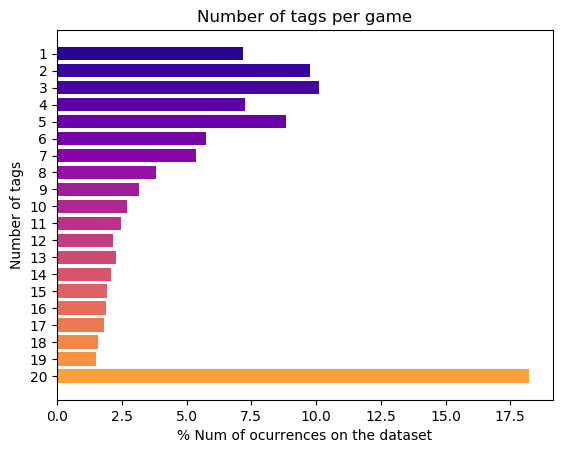

Most Frequent: [20] with 18.24 %
Top 5 tags: [20, 3, 2, 5, 4] with a total representation of 54.24%
Top 2 to 5 total repesentation: 36.01%


In [426]:
y_labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] #thre are up to 20 unique tags per game

cmap = cm.get_cmap('plasma')

color = []
for i in range(20):
    color.append(cmap(i*10 + 10))

tag_amnt = (data["tag_amnt"].value_counts() / len(data)) * 100 # getting the %
tag_amnt = tag_amnt.sort_index(ascending=True)

sum_tag_amnt_df = pd.DataFrame(tag_amnt)

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y_labels, tag_amnt,  align='center', color =  color)
ax.set_yticks(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% Num of ocurrences on the dataset')
ax.set_ylabel('Number of tags')
ax.set_title('Number of tags per game')
plt.show()

sum_tag_amnt_df = sum_tag_amnt_df.sort_values('tag_amnt',ascending=False)
most_frequent_percent = round(sum_tag_amnt_df['tag_amnt'].iloc[0],2)
representation_of_top_5 = round(sum_tag_amnt_df['tag_amnt'].iloc[0:5].sum(),2)
representation_of_top_2_to_5 = round(sum_tag_amnt_df['tag_amnt'].iloc[1:5].sum(),2)

print(f'Most Frequent: [{sum_tag_amnt_df.iloc[0].name}] with {most_frequent_percent} %\nTop 5 tags: {list(sum_tag_amnt_df.iloc[:5].index)} with a total representation of {representation_of_top_5}%\nTop 2 to 5 total repesentation: {representation_of_top_2_to_5}%')


About 18% of the games have 20 tags and 36% have between 2-5 tags.

Now lets see which are the most common tags.

In [427]:
#transforming the tags into a list, this function will also be usefull when we see the generes
def split_into_list(value):
    return value.split(",")

data['tags'] = data["tags"].apply(split_into_list)

In [428]:
#creating a function reduce the dimensionality of the data
def to_1D(series):
    return [x for _list in series for x in _list]

#Separating the tags into a new df
tags_df = to_1D(data['tags'])
tags_df= pd.DataFrame(tags_df)
tags_df = tags_df.rename(columns={0:'tag'},inplace=False)
tags_df.head()

,tag
0,FPS
1,Dungeon Crawler
2,Action
3,Puzzle
4,Action-Adventure


In [429]:
tags_df.value_counts()

tag         
Indie           27000
Action          18475
Casual          17279
Adventure       15513
Singleplayer    14643
                ...  
Hardware            8
Well-Written        8
BMX                 7
Reboot              4
Boss Rush           4
Length: 427, dtype: int64

There are 427 diferent tags in the dataset.

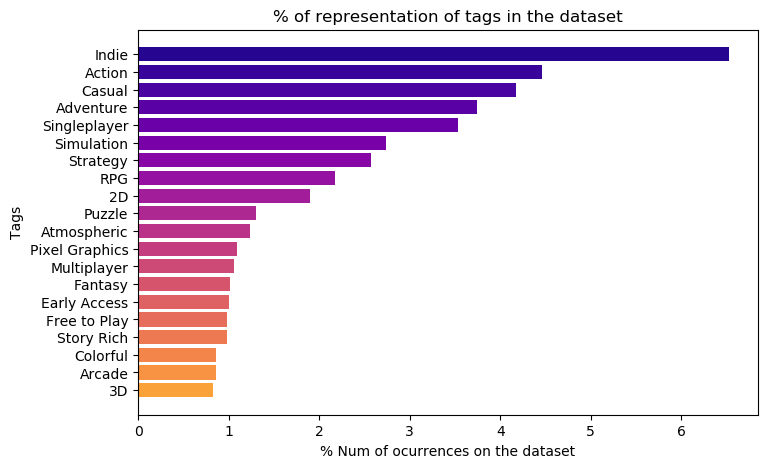

top_5_representation 22.44%
amnt_picked_representation 43.06%


,tag,%
0,Indie,6.52
1,Action,4.46
2,Casual,4.17
3,Adventure,3.75
4,Singleplayer,3.54
5,Simulation,2.74
6,Strategy,2.58
7,RPG,2.18
8,2D,1.89
9,Puzzle,1.31


In [430]:
AMNT_TAGS_TO_SEE = 20

y_labels = []
for i in range(AMNT_TAGS_TO_SEE):
    y_labels.append(tags_df['tag'].value_counts().keys()[:AMNT_TAGS_TO_SEE][i])

cmap = cm.get_cmap('plasma')

color = []
for i in range(20):
    color.append(cmap(i * 10 + 10))
    
tag_amnt = (tags_df["tag"].value_counts()[:AMNT_TAGS_TO_SEE] / len(tags_df)) * 100 # getting the %
tag_amnt = tag_amnt.sort_values(ascending=False)

plt.rcdefaults()
fig, ax = plt.subplots(figsize =(8, AMNT_TAGS_TO_SEE / 4))

ax.barh(y_labels, tag_amnt,  align='center', color =  color)
ax.set_yticks(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% Num of ocurrences on the dataset')
ax.set_ylabel('Tags')
ax.set_title('% of representation of tags in the dataset')
plt.show()

top_5_representation = round(tag_amnt[:5].sum(),2)
amnt_picked_representation = round(tag_amnt[:AMNT_TAGS_TO_SEE].sum(),2)
print(f'top_5_representation {top_5_representation}%\namnt_picked_representation {amnt_picked_representation}%')
tag_representation_df = pd.DataFrame(round(tag_amnt,2)).sort_values('tag',ascending=False).reset_index().rename(columns={'index':'tag','tag':'%'},inplace=False)
tag_representation_df

The most common tag is Indie representing 6.5% of the games being ahead from the next by 2% . The top 5 tags(Indie, Action, Casual, Adventure and Singleplayer) are found in 22.4% of the games. But is there a pattern with tags and the metascore?

In [431]:
def are_tags_in_list(_list, tag):
    if _list: 
        if tag in _list:
            return True
    else:
        return False

In [432]:
tag_scores = {}
tag_list = list(tags_df['tag'].value_counts().keys())

for tag in tag_list:
    data['is_tag_in_tags']=[are_tags_in_list(tags,tag) for tags in data['tags']]
    tag_scores[tag] = data.loc[data.is_tag_in_tags == True]['metascore'].mean()

In [433]:
data_items = tag_scores.items()
tag_score_df = pd.DataFrame(list(data_items)) 

tag_score_df = tag_score_df.rename(columns={0:'tag',1:'avg_score'},inplace=False)
tag_score_df['avg_score'] = round(tag_score_df['avg_score'],2)
tag_score_df = tag_score_df.sort_values('avg_score',ascending=False)
tag_score_df

,tag,avg_score
410,Rock Music,87.0
403,Baseball,86.0
331,Looter Shooter,83.0
338,Archery,82.5
424,BMX,82.0
...,...,...
413,Instrumental Music,NaN
414,Benchmark,NaN
416,Feature Film,NaN
421,8-bit Music,NaN


In [434]:
tag_score_df.isna().sum()

tag           0
avg_score    19
dtype: int64

there are 19 null values going to fill them with mean

In [435]:
tag_score_df['avg_score'] = tag_score_df['avg_score'].fillna(tag_score_df['avg_score'].mean())
tag_score_df = tag_score_df.sort_values('avg_score',ascending=False)

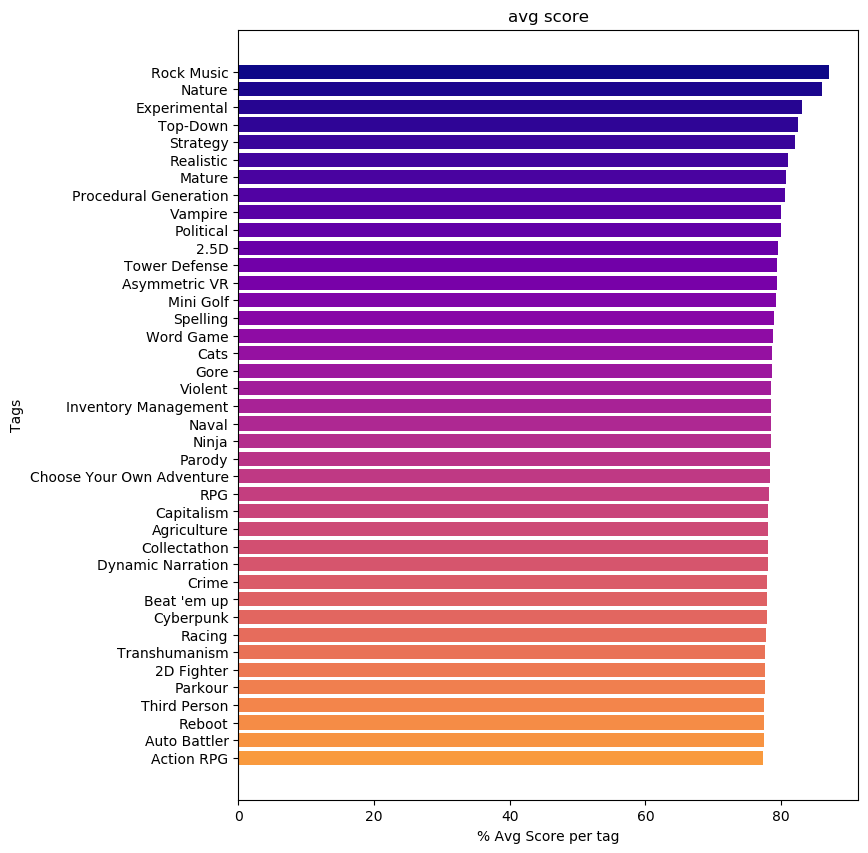

,Name,avg_score
410,Rock Music,87.00
403,Nature,86.00
331,Experimental,83.00
338,Top-Down,82.50
424,Strategy,82.00
279,Realistic,81.00
281,Mature,80.71
325,Procedural Generation,80.60
387,Vampire,80.00
344,Political,80.00


In [436]:
AMNT_TAGS_TO_SEE = 40
if(AMNT_TAGS_TO_SEE > len(tag_score_df)):
    AMNT_TAGS_TO_SEE = len(tag_score_df)
    
y_labels = []
for i in range(AMNT_TAGS_TO_SEE):
    y_labels.append(tag_score_df['tag'].value_counts().keys()[:AMNT_TAGS_TO_SEE][i])

cmap = cm.get_cmap('plasma')

color = []
for i in range(40):
    color.append(cmap(i*5))
    
tag_amnt = tag_score_df["avg_score"][:AMNT_TAGS_TO_SEE]
tag_amnt = tag_amnt.sort_values(ascending=False)

plt.rcdefaults()
fig, ax = plt.subplots(figsize =(8, AMNT_TAGS_TO_SEE / 4))

ax.barh(y_labels, tag_amnt,  align='center', color =  color)
ax.set_yticks(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% Avg Score per tag')
ax.set_ylabel('Tags')
ax.set_title('avg score')
plt.show()
df = pd.DataFrame(round(tag_amnt,2)).sort_values('avg_score',ascending=False)
df['tags'] = y_labels
df.insert(0, 'Name', df.pop('tags'))
df

In [437]:
tag_score_df.describe()

,avg_score
count,427.000000
mean,73.618333
std,3.298303
min,59.500000
25%,72.335000
50%,73.670000
75%,75.315000
max,87.000000


Seems that the best scored tags are Rock Music and nature. Lets see the underperformers

In [438]:
tag_score_df.loc[tag_score_df.avg_score <= tag_score_df.avg_score.mean()]

,tag,avg_score
13,Fantasy,73.56
273,Time Travel,73.55
102,Historical,73.55
312,Kickstarter,73.54
106,Roguelite,73.53
...,...,...
399,Wrestling,62.00
332,Soccer,62.00
362,Gambling,61.00
167,Animation & Modeling,60.00


189 tags have bellow avg scores, the worst seem to be : Intentionally Awkward Controls, Animation & Modeling, Gambling, Soccer and Wrestling. Now lets check the generes.

## 2.2 Genres Analysis

(<matplotlib.axes._subplots.AxesSubplot at 0x275cdbeafc8>,
 3     12576
 2     11894
 1     11267
 4      5516
 5      2574
 6       955
 7       295
 8       243
 9        16
 10        9
 11        4
 12        1
 Name: gen_amnt, dtype: int64)

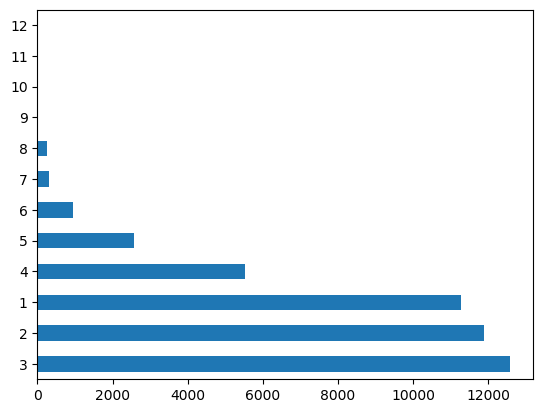

In [439]:
data["gen_amnt"]  = data["genres"].apply(count_tags)

data["gen_amnt"].value_counts().plot(kind="barh") , data["gen_amnt"].value_counts()

The mayority of the games have between 1-3 genres and there seem to be very few with more than 6 tags, lets see them to ensure that they are not scuffed.

In [440]:
data.loc[data.gen_amnt > 6].loc[data.metascore > 0].head()  #Checking if there are any games with a metascore
print("---------------------------------")
data.loc[data.gen_amnt > 6].head()

---------------------------------


,app_name,publisher,discount_price,early_access,genres,id,metascore,price,developer,release_date,reviews_url,sentiment,tags,title,url,tag_amnt,is_tag_in_tags,gen_amnt
88,深海捕鱼/Deep Fishing,Edler Fish Studio,0.00,1,"Adventure,Casual,Free to Play,Indie,Massively ...",1648550.0,NaN,0.00,Edler Fish StudioEdler Fish Studio,26 Jan 2022,http://steamcommunity.com/app/1648550/reviews/...,Positive,"[Casual, Free to Play, Simulation, Early Acces...",深海捕鱼/Deep Fishing,https://store.steampowered.com/app/1648550/Dee...,15,None,8
143,Catch them!,LTZinc,8.39,0,"Action,Adventure,Casual,Indie,Massively Multip...",1862500.0,NaN,13.99,LTZincLTZinc,21 Jan 2022,http://steamcommunity.com/app/1862500/reviews/...,Positive,"[Casual, Adventure, Simulation, 2D, Indie, Sur...",Catch them!,https://store.steampowered.com/app/1862500/Cat...,20,None,8
372,Engine Evolution 2021,Petr Šimůnek,0.00,0,"Action,Casual,Free to Play,Indie,Massively Mul...",1589770.0,NaN,0.00,Petr ŠimůnekPetr Šimůnek,12 Jan 2022,http://steamcommunity.com/app/1589770/reviews/...,Mostly Positive,"[Racing, Action, Multiplayer, Realistic, Sport...",Engine Evolution 2021,https://store.steampowered.com/app/1589770/Eng...,20,None,8
462,Zombies Killer Machine,"Atomic Fabrik, Cristian Manolachi",13.99,0,"Action,Adventure,Casual,Indie,Racing,Simulatio...",1850690.0,NaN,13.99,"Atomic Fabrik, Cristian ManolachiAtomic Fabrik...",6 Jan 2022,http://steamcommunity.com/app/1850690/reviews/...,Unknown,"[Action, Adventure, Casual, Racing, Simulation...",Zombies Killer Machine,https://store.steampowered.com/app/1850690/Zom...,20,None,8
521,At Home Alone Final,0Cube,0.00,0,"Adventure,Casual,Free to Play,Indie,RPG,Simula...",1740100.0,NaN,0.00,阿正不经0Cube,0CubeFranchise:0Cube 31 Dec 2021,http://steamcommunity.com/app/1740100/reviews/...,Overwhelmingly Positive,"[RPG, Horror, Psychological Horror, Drama, Pix...",At Home Alone Final,https://store.steampowered.com/app/1740100/At_...,20,None,7


It seems that none of this games have a meta score but the genre col seems fine so I'll continue to study them

In [441]:
data['genres'] = data["genres"].apply(split_into_list)

In [442]:
genres_df = to_1D(data['genres'])
genres_df= pd.DataFrame(genres_df)
genres_df = genres_df.rename(columns={0:'genre'},inplace=False)
genres_df.head() , len(genres_df.value_counts())

(          genre
 0        Action
 1     Adventure
 2  Early Access
 3        Casual
 4         Indie,
 24)

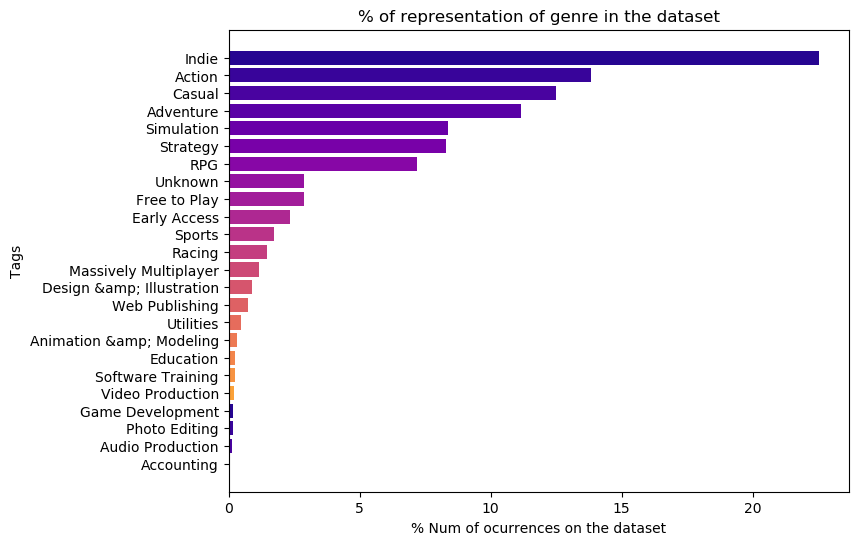

top_5_representation 68.39%
amnt_picked_representation 100.0%


,genre,%
0,Indie,22.54
1,Action,13.83
2,Casual,12.52
3,Adventure,11.15
4,Simulation,8.36
5,Strategy,8.30
6,RPG,7.17
7,Unknown,2.89
8,Free to Play,2.87
9,Early Access,2.33


In [443]:
AMNT_TAGS_TO_SEE = 24

y_labels = []
for i in range(AMNT_TAGS_TO_SEE):
    y_labels.append(genres_df['genre'].value_counts().keys()[:AMNT_TAGS_TO_SEE][i])

cmap = cm.get_cmap('plasma')

color = []
for i in range(20):
    color.append(cmap(i * 10 + 10))
    
gen_amnt = (genres_df["genre"].value_counts()[:AMNT_TAGS_TO_SEE] / len(genres_df)) * 100 # getting the %
gen_amnt = gen_amnt.sort_values(ascending=False)

plt.rcdefaults()
fig, ax = plt.subplots(figsize =(8, AMNT_TAGS_TO_SEE / 4))

ax.barh(y_labels, gen_amnt,  align='center', color =  color)
ax.set_yticks(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% Num of ocurrences on the dataset')
ax.set_ylabel('Tags')
ax.set_title('% of representation of genre in the dataset')
plt.show()

top_5_representation = round(gen_amnt[:5].sum(),2)
amnt_picked_representation = round(gen_amnt[:AMNT_TAGS_TO_SEE].sum(),2)
print(f'top_5_representation {top_5_representation}%\namnt_picked_representation {amnt_picked_representation}%')
genre_representation_df = pd.DataFrame(round(gen_amnt,2)).sort_values('genre',ascending=False).reset_index().rename(columns={'index':'genre','genre':'%'},inplace=False)
genre_representation_df

The most common genres are the same as the most common tags (Indie,Action ,Casual, Simulation and Adventure) they represent 68% of the games

In [444]:
gen_scores = {}
gen_list = list(genres_df['genre'].value_counts().keys())

for gen in gen_list:
    data['is_gen_in_genres']=[are_tags_in_list(genres,gen) for genres in data['genres']]
    gen_scores[gen] = data.loc[data.is_gen_in_genres == True]['metascore'].mean()
    
data_items = gen_scores.items()
gen_score_df = pd.DataFrame(list(data_items)) 

gen_score_df = gen_score_df.rename(columns={0:'genre',1:'avg_score'},inplace=False)
gen_score_df['avg_score'] = round(gen_score_df['avg_score'],2)
gen_score_df = gen_score_df.sort_values('avg_score',ascending=False)

gen_score_df

,genre,avg_score
9,Early Access,78.33
12,Massively Multiplayer,75.31
8,Free to Play,73.88
7,Unknown,73.45
6,RPG,72.91
5,Strategy,72.69
10,Sports,72.01
3,Adventure,71.85
2,Casual,71.83
1,Action,71.74


The most popular genres are MMO, early access ,Free to play ,rpg and strategy

In [445]:
gen_score_df.describe()

,avg_score
count,13.000000
mean,72.972308
std,1.967482
min,71.460000
25%,71.740000
50%,72.010000
75%,73.450000
max,78.330000


In [446]:
#Going to fill null values with mean
gen_score_df['avg_score'] = gen_score_df['avg_score'].fillna(round(gen_score_df['avg_score'].mean(),2))
gen_score_df = gen_score_df.sort_values('avg_score',ascending=False)
gen_score_df

,genre,avg_score
9,Early Access,78.33
12,Massively Multiplayer,75.31
8,Free to Play,73.88
7,Unknown,73.45
14,Web Publishing,72.97
22,Audio Production,72.97
21,Photo Editing,72.97
20,Game Development,72.97
19,Video Production,72.97
18,Software Training,72.97


## Summary of what we learned so far respective to the tag and genres cols:
* Most liked genres are Early Access, MMO, Free To play and RPG.
* Most liked tags are Rock Music, Nature, Experimental, Top-down and strategy.
* 68% of the games are from Indie, Action, Casual, Simulation and Adventure genres and as tags they can be found in 22% of the games.
* Most common tag is Indie with 6.5% representation.

### As for the missing metascore values
I can calculate a more accurate user score with the mean scores of the tag_score_avg and gen_score_avg  by calculateing the mean of all tags and genres scores convined, as for unknowns I'll use the avg of the metascores after. 

After fixing the metascores I'll see how the avg score of each genre evolved over time.

In [447]:
def get_avg_in_tag(value):
    score = 0
    if value:
        for tag in value:
            score = score + tag_score_df.loc[tag_score_df.tag == tag]['avg_score'].iloc[0]
    return round((score / len(value)),2)

def get_avg_in_genre(value):
    score = 0
    if value:
        for genre in value:
            score = score + gen_score_df.loc[gen_score_df.genre == genre]['avg_score'].iloc[0]
    return round((score / len(value)),2)

In [448]:
data['tag_avg_metascore'] = data['tags'].apply(get_avg_in_tag)
data['genre_avg_metascore'] = data['genres'].apply(get_avg_in_genre)

In [449]:
data.head()

,app_name,publisher,discount_price,early_access,genres,id,metascore,price,developer,release_date,...,sentiment,tags,title,url,tag_amnt,is_tag_in_tags,gen_amnt,is_gen_in_genres,tag_avg_metascore,genre_avg_metascore
0,Gogte,OsoArcade,78.99,1,"[Action, Adventure, Early Access]",1440910.0,NaN,78.99,OsoOsoArcade,28 Jan 2022,...,Unknown,"[FPS, Dungeon Crawler, Action, Puzzle, Action-...",Gogte,https://store.steampowered.com/app/1440910/Gogte/,19,None,3,None,72.52,73.97
1,I've Seen Everything - More Fishes,NLB project,0.00,0,"[Casual, Indie]",1807515.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,...,Unknown,"[Indie, Casual]",I've Seen Everything - More Fishes,https://store.steampowered.com/app/1807515/Ive...,2,None,2,None,72.12,71.77
2,I've Seen Everything - More Dinosaurs,NLB project,0.00,0,"[Casual, Indie]",1807514.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,...,Unknown,"[Indie, Casual]",I've Seen Everything - More Dinosaurs,https://store.steampowered.com/app/1807514/Ive...,2,None,2,None,72.12,71.77
3,Mini Mini-Golf,Piece Of Voxel,77.99,0,"[Casual, Indie, Simulation, Sports, Strategy]",1874400.0,NaN,129.99,Piece Of VoxelPiece Of Voxel,28 Jan 2022,...,Unknown,"[Casual, Golf, Simulation, Logic, Strategy, Fa...",Mini Mini-Golf,https://store.steampowered.com/app/1874400/Min...,20,None,5,None,73.37,71.94
4,Rogue Dungeon,Cerberus Gate Games,116.99,1,"[Indie, RPG, Strategy, Early Access]",1822640.0,NaN,129.99,Cerberus Gate GamesCerberus Gate Games,28 Jan 2022,...,Unknown,"[RPG, Adventure, Board Game, Dungeon Crawler, ...",Rogue Dungeon,https://store.steampowered.com/app/1822640/Rog...,19,None,4,None,73.83,73.91


In [450]:
data['avg_metascore'] = round(((data['tag_avg_metascore'] + data['genre_avg_metascore']) / 2),2)

In [451]:
data['metascore'] = data['metascore'].fillna(data['avg_metascore'])

In [452]:
data

,app_name,publisher,discount_price,early_access,genres,id,metascore,price,developer,release_date,...,tags,title,url,tag_amnt,is_tag_in_tags,gen_amnt,is_gen_in_genres,tag_avg_metascore,genre_avg_metascore,avg_metascore
0,Gogte,OsoArcade,78.99,1,"[Action, Adventure, Early Access]",1440910.0,73.24,78.99,OsoOsoArcade,28 Jan 2022,...,"[FPS, Dungeon Crawler, Action, Puzzle, Action-...",Gogte,https://store.steampowered.com/app/1440910/Gogte/,19,None,3,None,72.52,73.97,73.24
1,I've Seen Everything - More Fishes,NLB project,0.00,0,"[Casual, Indie]",1807515.0,71.94,0.00,NLB projectNLB project,28 Jan 2022,...,"[Indie, Casual]",I've Seen Everything - More Fishes,https://store.steampowered.com/app/1807515/Ive...,2,None,2,None,72.12,71.77,71.94
2,I've Seen Everything - More Dinosaurs,NLB project,0.00,0,"[Casual, Indie]",1807514.0,71.94,0.00,NLB projectNLB project,28 Jan 2022,...,"[Indie, Casual]",I've Seen Everything - More Dinosaurs,https://store.steampowered.com/app/1807514/Ive...,2,None,2,None,72.12,71.77,71.94
3,Mini Mini-Golf,Piece Of Voxel,77.99,0,"[Casual, Indie, Simulation, Sports, Strategy]",1874400.0,72.66,129.99,Piece Of VoxelPiece Of Voxel,28 Jan 2022,...,"[Casual, Golf, Simulation, Logic, Strategy, Fa...",Mini Mini-Golf,https://store.steampowered.com/app/1874400/Min...,20,None,5,None,73.37,71.94,72.66
4,Rogue Dungeon,Cerberus Gate Games,116.99,1,"[Indie, RPG, Strategy, Early Access]",1822640.0,73.87,129.99,Cerberus Gate GamesCerberus Gate Games,28 Jan 2022,...,"[RPG, Adventure, Board Game, Dungeon Crawler, ...",Rogue Dungeon,https://store.steampowered.com/app/1822640/Rog...,19,None,4,None,73.83,73.91,73.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45345,Frontline: World War II,Frontline: Games Series,82.49,0,"[Action, Casual, Indie, Simulation, Strategy]",1394500.0,72.84,149.99,Frontline: Games SeriesFrontline: Games Series,1 Jan 2021,...,"[Turn-Based Tactics, Turn-Based Strategy, Worl...",Frontline: World War II,https://store.steampowered.com/app/1394500/Fro...,20,None,5,None,73.79,71.89,72.84
45346,Unification,Unknown,0.00,1,[Unknown],1177340.0,73.25,0.00,Unknown,unknown,...,"[Early Access, Action Roguelike, Puzzle Platfo...",Unification,https://store.steampowered.com/app/1177340/Uni...,20,None,1,None,73.05,73.45,73.25
45347,Zoo Strikers,Big Dream,0.00,1,"[Action, Casual, Free to Play, Indie, Strategy...",685140.0,72.68,0.00,Big DreamBig Dream,2021,...,"[Free to Play, Casual, Indie, Action, Strategy...",Zoo Strikers,https://store.steampowered.com/app/685140/Zoo_...,6,None,6,None,72.01,73.36,72.68
45348,Deadly Maze,Sheer Studios,67.99,0,"[Action, Casual, Indie, Massively Multiplayer,...",1319060.0,72.70,67.99,Sheer StudiosSheer Studios,1 Jan 2021,...,"[Casual, Strategy, Action, Massively Multiplay...",Deadly Maze,https://store.steampowered.com/app/1319060/Dea...,5,None,5,None,72.74,72.66,72.70


## 2.3 Release date Analysis

In [453]:
#transforming the release date into date time
def clear_realease_date(value):
    try:
        if isinstance(value, datetime):
            return value
        elif 12 > len(value) > 8:
            return datetime.strptime(value, '%d %b %Y')
        else:
            return datetime.strptime(value[-11:], '%d %b %Y')
    except:
        return datetime.strptime('1 Jan 2022' , '%d %b %Y')  

In [454]:
data['release_date'] = data['release_date'].apply(clear_realease_date)
data['release_date'].value_counts()

2022-01-01    4464
2021-06-24      88
2020-03-23      88
2020-10-15      86
2017-08-31      82
              ... 
2015-01-03       1
1995-07-01       1
1985-01-01       1
2013-01-24       1
2021-01-02       1
Name: release_date, Length: 3988, dtype: int64

In [455]:
#plotting the scores over Monthly time, using exponential moveing avg to smooth them.

def plot_genre_timeline(genre,window=None,ema_value = 1,ylim = None,rule='M'):
    data['is_gen_in_genres']=[are_tags_in_list(genres,genre) for genres in data['genres']]
    scores = data.loc[data.is_gen_in_genres == True][['metascore','release_date']]
    scores = scores.sort_values('release_date',ascending=False)
    scores.set_index('release_date', inplace=True)
    scores[f'EMA_{ema_value}'] = scores['metascore'].ewm(alpha= ema_value, adjust = False).mean()
    scores.resample(rule=rule).mean()[[f'metascore',f'EMA_{ema_value}']].plot(figsize=(12,4),xlim=window, title= f'{genre} {rule} {window}', ylim= ylim)  
    
def plot_tag_timeline(tag,window=None,ema_value = 1,ylim = None,rule='M'):
    data['is_tag_in_tags']=[are_tags_in_list(tags,tag) for tags in data['tags']]
    scores = data.loc[data.is_tag_in_tags == True][['metascore','release_date']]
    scores = scores.sort_values('release_date',ascending=False)
    scores.set_index('release_date', inplace=True)
    scores[f'EMA_{ema_value}'] = scores['metascore'].ewm(alpha= ema_value, adjust = False).mean()
    scores.resample(rule=rule).mean()[[f'metascore',f'EMA_{ema_value}']].plot(figsize=(12,4),xlim=window, title= f'{tag} {rule} {window}', ylim= ylim)  


In [456]:
TIMEWINDOW = ['2008-01-01','2022-01-01']
MIN_MAX_SCORE_WINDOW = (60,90)
EMA_VALUE = 0.5
RULE = 'M'

Let's see if there is a trend with the metascores over time of the top 5 categories since 2008

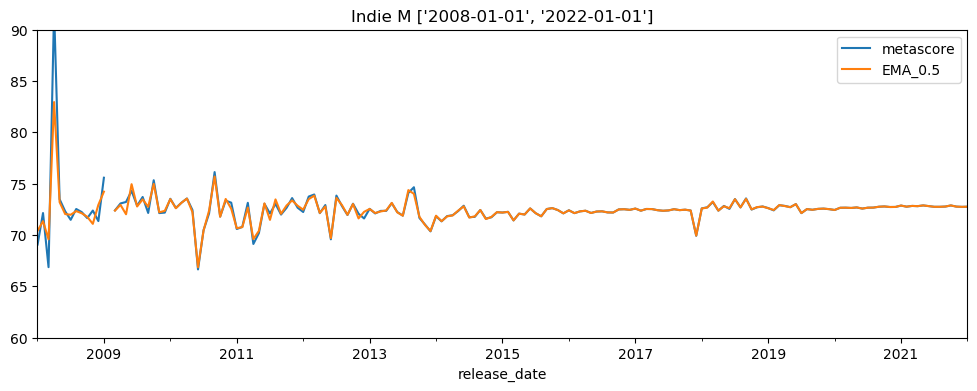

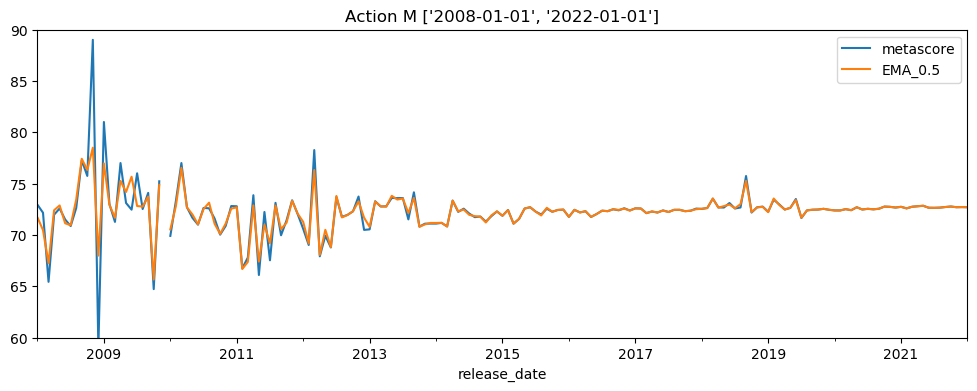

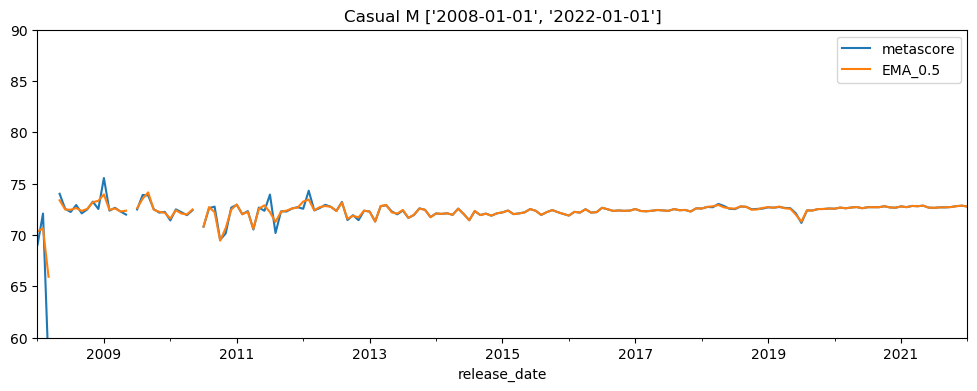

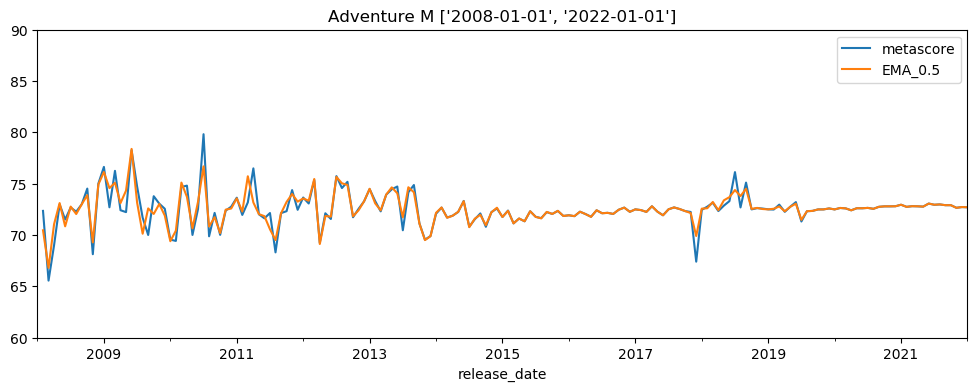

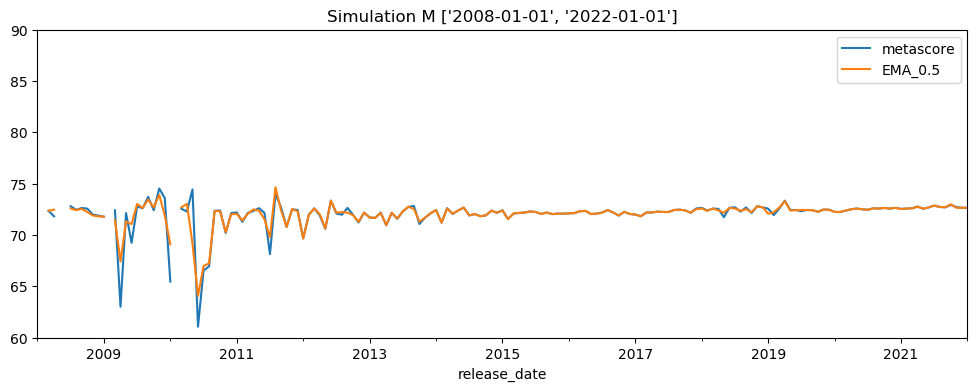

In [457]:
for genre in genre_representation_df.iloc[:5]['genre']:
    plot_genre_timeline(genre,window=TIMEWINDOW,ema_value=EMA_VALUE,ylim=MIN_MAX_SCORE_WINDOW, rule=RULE)

They all follow the same pattern, they start noisy and then trend to the avg the exception is the Simulation category where it seems that the games got low scores until 2011. Indie and Adventure categories got a bit lower around last quarter of 2017 and recovered while Action and Adventure got an increse around mid-late 2018

Lets see compare Singleplayer games vs Multiplayer and Co-op

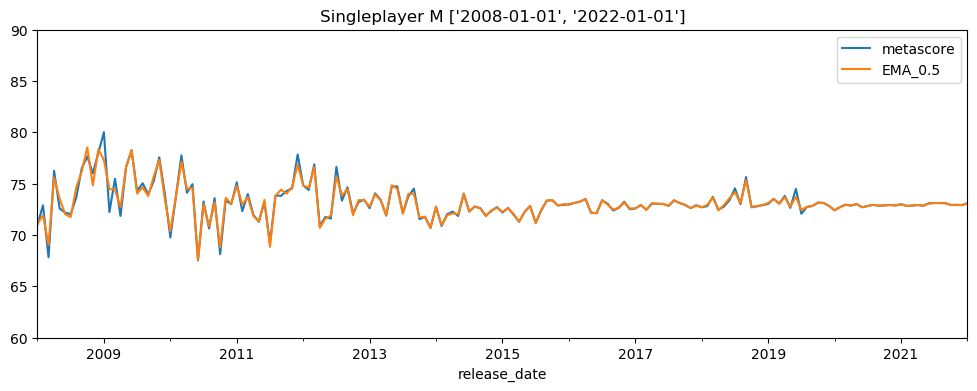

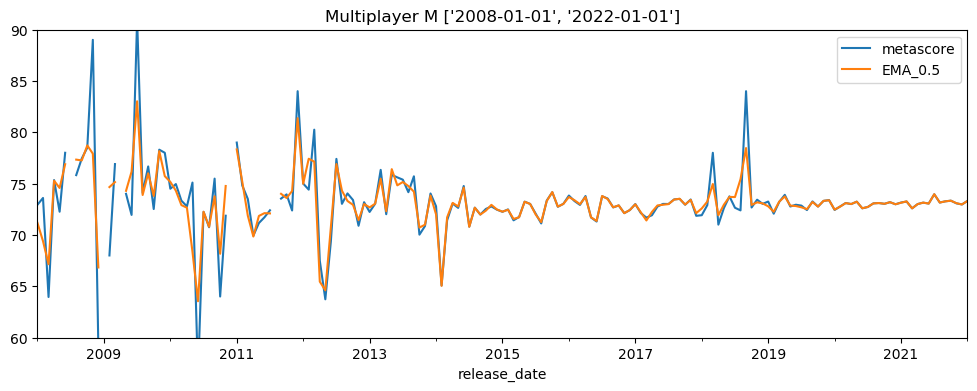

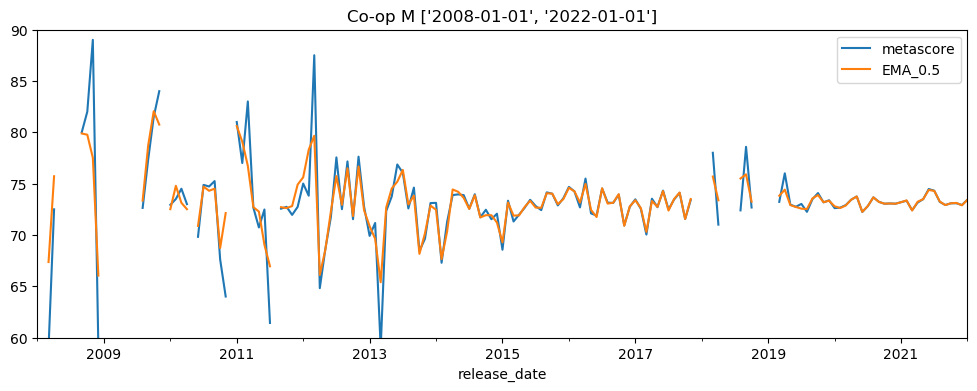

In [458]:
tags = ['Singleplayer','Multiplayer','Co-op']
for tag in tags:
    plot_tag_timeline(tag,window=TIMEWINDOW,ema_value=EMA_VALUE,ylim=MIN_MAX_SCORE_WINDOW, rule=RULE)

They perfomed simillary, Multiplayer games released in late 2018 got significantly higher scores than the rest. Co-op graph has a lot of gaps because there are few games tagged as so.
Now lets see how FPS performed vs RPG vs third person shooters and some other types of games.

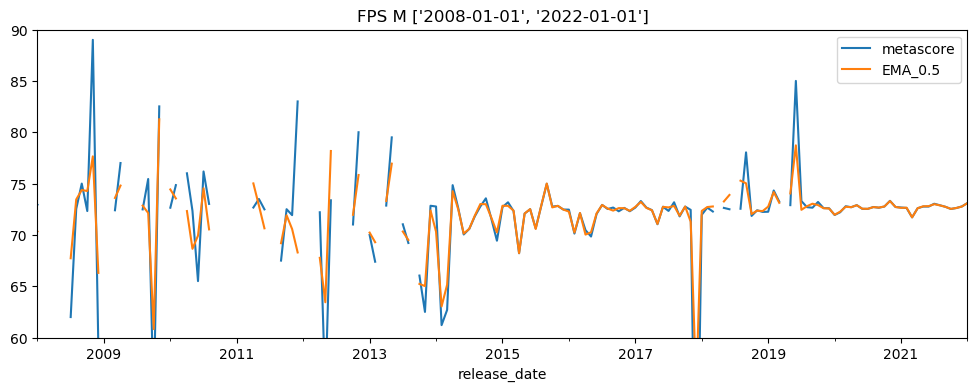

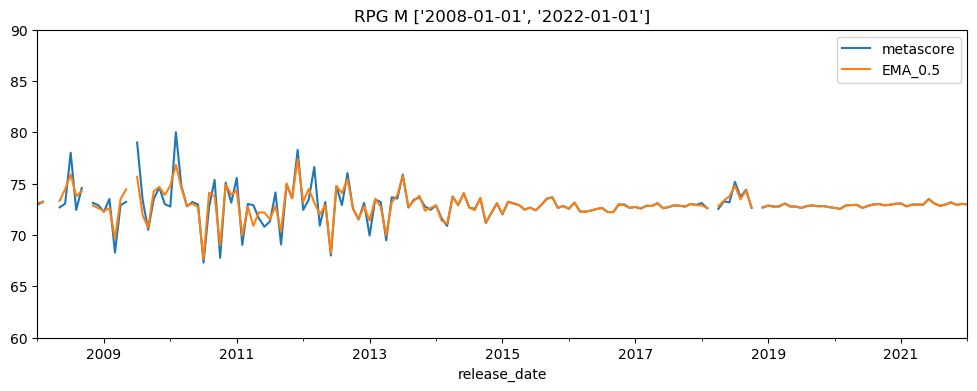

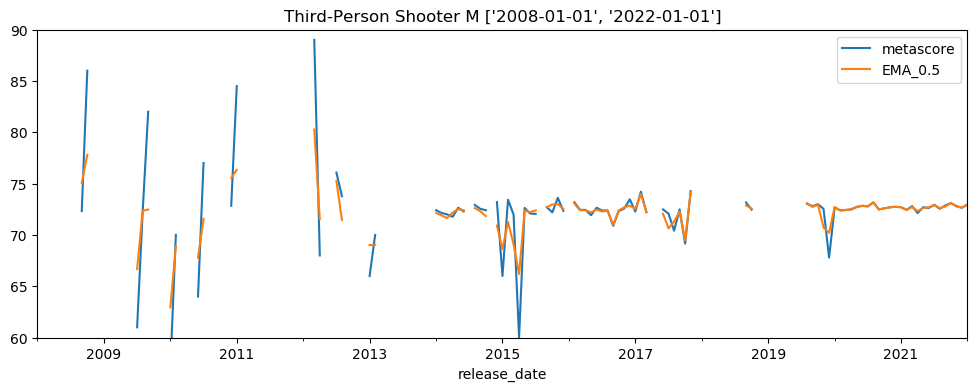

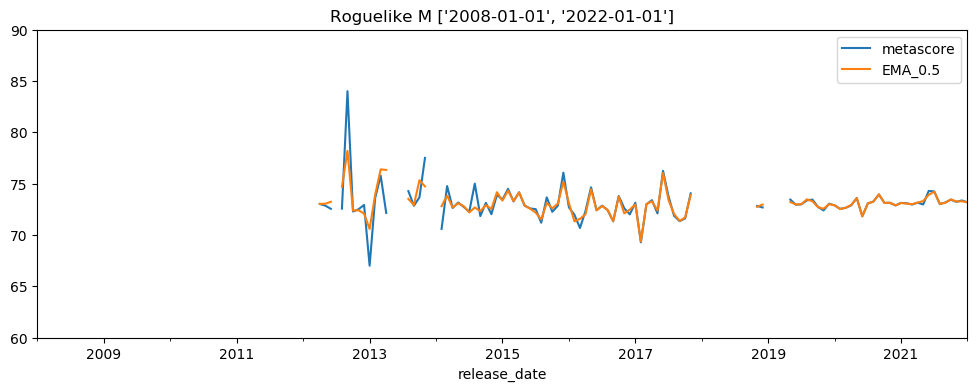

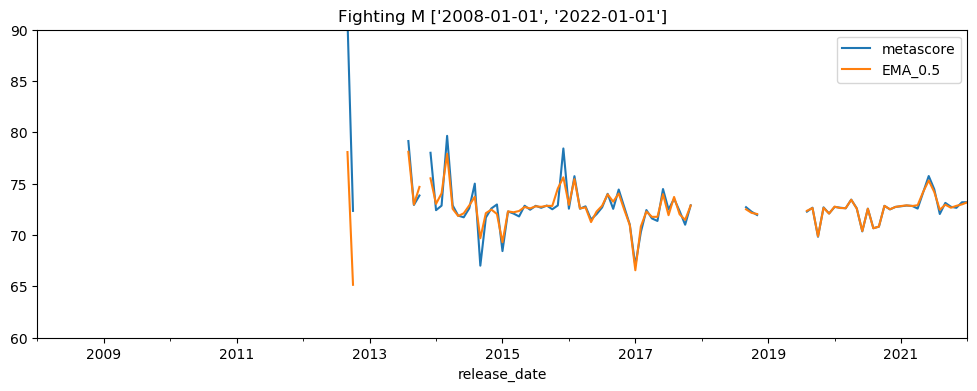

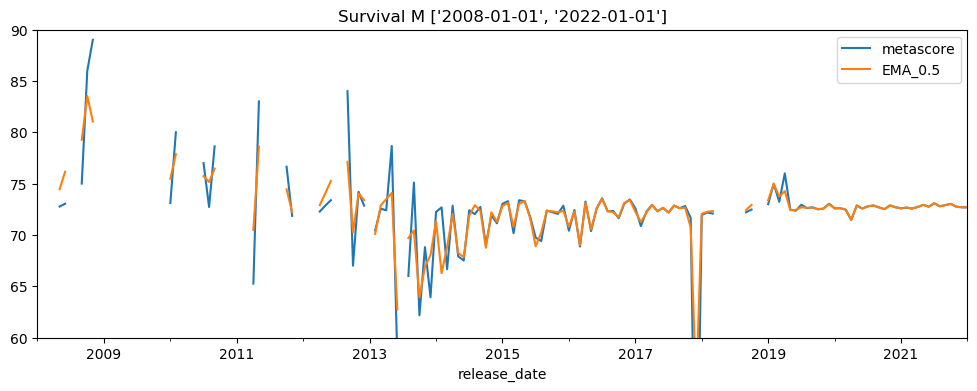

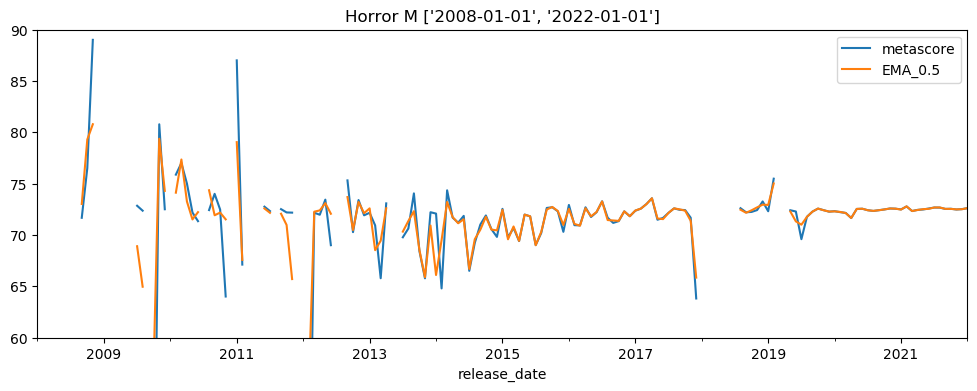

In [459]:
tags = ['FPS','RPG','Third-Person Shooter','Roguelike','Fighting','Survival','Horror']
for tag in tags:
    plot_tag_timeline(tag,window=TIMEWINDOW,ema_value=EMA_VALUE,ylim=MIN_MAX_SCORE_WINDOW, rule=RULE)

There aren't many third person shooters to compare, but they had a big low in 2015.Rogue-Likes start appearing in 2012 and there is a gap in 2018.
Survival Games from late 2017- early 2018 got pretty good metascores.Fighting games got bad scores on 2017 but it seems that they been getting better on the course of 2021.The RPG and horror ones look like the genre graphs pretty avg, the fps one on the other hand seems interesting.There is a huge down on late 2017 and then a big up in mid 2019. Going to double check the downspike to see if its not a fluke or a scrapper problem.

In [460]:
data['is_tag_in_tags']=[are_tags_in_list(tags,'FPS') for tags in data['tags']]
data.loc[data.is_tag_in_tags == True].loc[data.metascore < 60].loc[ data.release_date > '2017-01-01'].loc[ data.release_date < '2018-01-01']

,app_name,publisher,discount_price,early_access,genres,id,metascore,price,developer,release_date,...,tags,title,url,tag_amnt,is_tag_in_tags,gen_amnt,is_gen_in_genres,tag_avg_metascore,genre_avg_metascore,avg_metascore
27330,Hello Neighbor,tinyBuild,23.74,0,"[Adventure, Indie, Strategy]",521890.0,38.0,23.74,Dynamic PixelstinyBuild,2017-12-08,...,"[Horror, Sandbox, Action-Adventure, Survival H...",Hello Neighbor,https://store.steampowered.com/app/521890/Hell...,20,True,3,None,72.36,72.08,72.22
27950,Inner Chains,IMGN.PRO,44.99,0,"[Action, Adventure]",537430.0,40.0,224.99,Telepaths TreeIMGN.PRO,2017-05-18,...,"[Action, Adventure, Horror, Atmospheric, FPS, ...",Inner Chains,https://store.steampowered.com/app/537430/Inne...,6,True,2,None,72.07,71.79,71.93


After checking: the first game was some scrapper problem or the game got review bombed the moment of scrapping since on the store page it has around 88% of metascore. As for the second one it matches perfectly the storepage. I'm going to fix the bad score. 

In [461]:
data['metascore'].loc[27330] = 88.0

C:\Users\agust\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [462]:
data.loc[data.is_tag_in_tags == True].loc[data.metascore < 60].loc[ data.release_date > '2017-01-01'].loc[ data.release_date < '2018-01-01']

,app_name,publisher,discount_price,early_access,genres,id,metascore,price,developer,release_date,...,tags,title,url,tag_amnt,is_tag_in_tags,gen_amnt,is_gen_in_genres,tag_avg_metascore,genre_avg_metascore,avg_metascore
27950,Inner Chains,IMGN.PRO,44.99,0,"[Action, Adventure]",537430.0,40.0,224.99,Telepaths TreeIMGN.PRO,2017-05-18,...,"[Action, Adventure, Horror, Atmospheric, FPS, ...",Inner Chains,https://store.steampowered.com/app/537430/Inne...,6,True,2,None,72.07,71.79,71.93


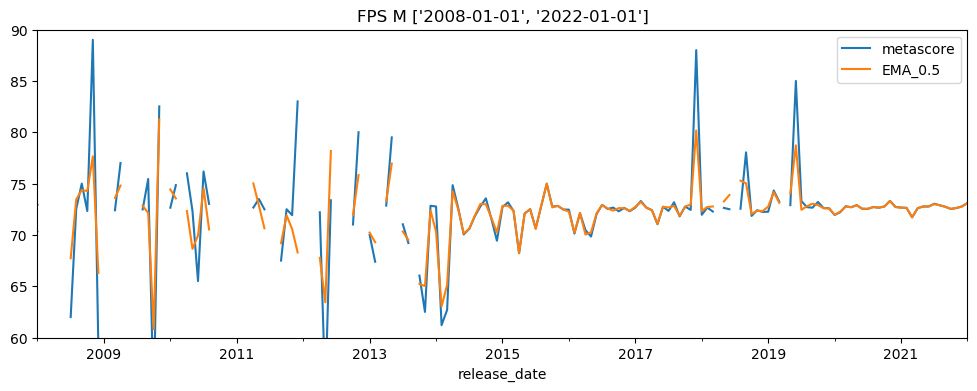

In [463]:
#Rechecking the fps graph after fix
plot_tag_timeline('FPS',window=TIMEWINDOW,ema_value=EMA_VALUE,ylim=MIN_MAX_SCORE_WINDOW, rule=RULE)

Ok, now that the fps tag got fixed we can see that the abnormal down turned into a small down dip. Games realeased on late 2017 and mid 2019 have high metascores.

Now let's Check how the publishers and developers are related to the metascores and if the quality of their games changed over time.

## 2.4 Publishers Analysis

In [464]:
data['publisher'].value_counts()

Unknown                       7998
TigerQiuQiu                    790
Degica                         761
KOEI TECMO GAMES CO., LTD.     652
Dovetail Games - Trains        374
                              ... 
RipTyde Studio                   1
PhyzixMind                       1
Mushroom Angels Games            1
Flight School Studio             1
Myrtilus Entertainment           1
Name: publisher, Length: 16859, dtype: int64

In [465]:
publishers_to_analize = pd.DataFrame(data.loc[data.publisher != 'Unknown']['publisher'])#Ignoring Unkown publishers

In [466]:
def count_games_for_publisher(value):
    return len(publishers_to_analize.loc[data.publisher == value])

def get_overall_avg_score_of_publisher(value):
    return data.loc[data.publisher == value]['metascore'].mean()

In [467]:
publishers_to_analize['games_released'] = publishers_to_analize['publisher'].apply(count_games_for_publisher)
publishers_to_analize['avg_publisher_score'] = publishers_to_analize['publisher'].apply(get_overall_avg_score_of_publisher)

In [468]:
publishers_to_analize = publishers_to_analize.drop_duplicates(subset=['publisher']).reset_index().set_index('publisher')
del publishers_to_analize['index']

In [469]:
publishers_to_analize.describe()

,games_released,avg_publisher_score
count,16858.000000,16858.000000
mean,2.215684,72.618279
std,12.275620,2.094209
min,1.000000,27.000000
25%,1.000000,72.320000
50%,1.000000,72.670000
75%,1.000000,72.980000
max,790.000000,97.000000


,games_released,avg_publisher_score
publisher,,
TigerQiuQiu,790,72.436595
Degica,761,73.366728
"KOEI TECMO GAMES CO., LTD.",652,72.367469
Dovetail Games - Trains,374,71.991257
Paradox Interactive,267,72.857191
Ubisoft,253,72.558893
Big Fish Games,234,72.194786
"CAPCOM Co., Ltd.",186,72.093065
Dovetail Games - Flight,179,71.740279


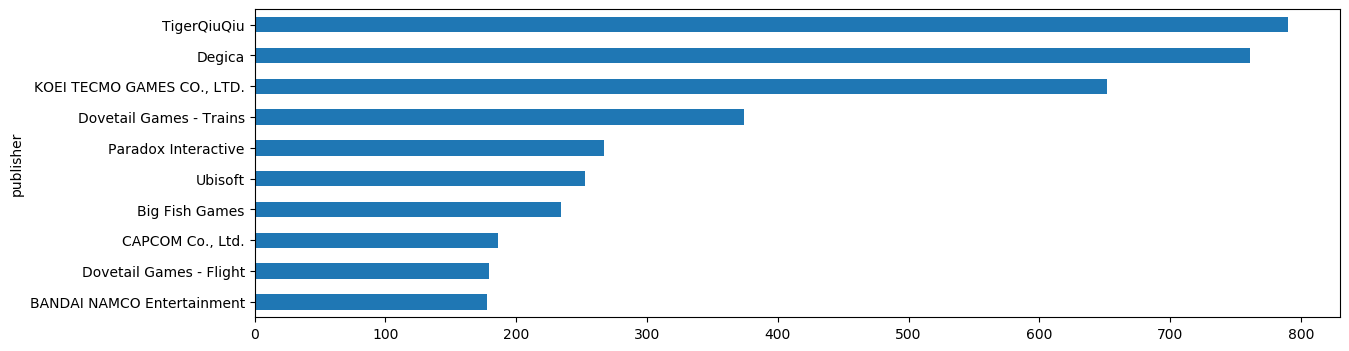

In [470]:
AMT_TO_SEE = 10

publishers_to_analize = publishers_to_analize.sort_values('games_released',ascending=False)
publishers_to_analize.iloc[:AMT_TO_SEE]['games_released'].sort_values(ascending=True).plot(kind='barh', figsize=(14,4))
publishers_to_analize[:AMT_TO_SEE]

TigerQiuQiu and Degica are the publishers with the most games.
Let's see which publishers have the best avg scores, I'll se the scores of publishers with more than 20 games published. I've chosen 20 arbitrarily beacuse if it was less the amount of games will not be representative of the publisher quality.

,games_released,avg_publisher_score
publisher,,
Stardock Entertainment,21,77.143810
Activision,25,75.817600
"LucasArts, Lucasfilm, Disney",25,75.685600
"2K, Aspyr (Mac), Aspyr (Linux)",22,75.023182
"Spike Chunsoft Co., Ltd.",36,74.403611
Devolver Digital,53,74.311509
HeR Interactive,28,74.106429
Electronic Arts,134,73.958657
Xbox Game Studios,53,73.947170


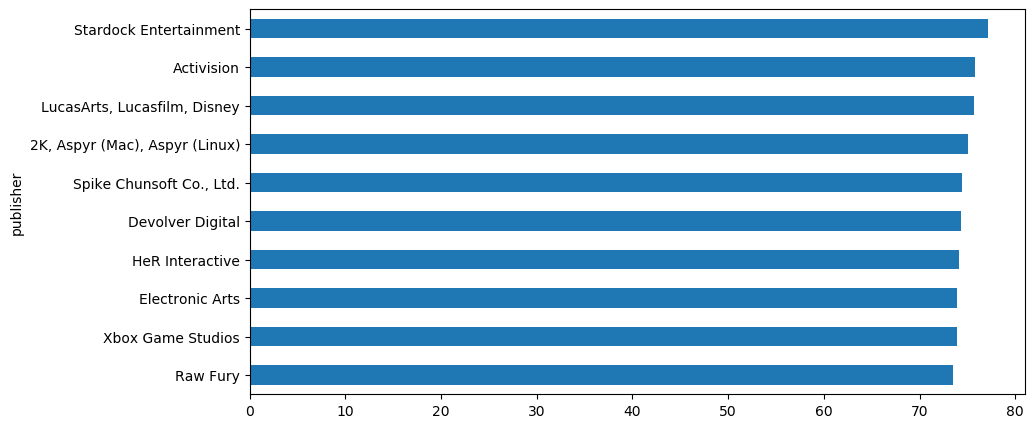

In [471]:
publishers_to_analize = publishers_to_analize.sort_values('avg_publisher_score',ascending=False)
publishers_to_analize.loc[publishers_to_analize.games_released > 20].iloc[:AMT_TO_SEE]['avg_publisher_score'].sort_values(ascending=True).plot(kind='barh', figsize=(10,5))
publishers_to_analize.loc[publishers_to_analize.games_released > 20].iloc[:AMT_TO_SEE]

Stardock entretainment seems to be the publisher with the best Avg score, followed by activition, LucasArts and 2k , Now lets see the worst publishers

,games_released,avg_publisher_score
publisher,,
1C Entertainment,92,70.283696
Deep Silver,27,70.665926
Viva Media,35,70.763714
Focus Home Interactive,57,70.768246
"XSEED Games, Marvelous USA, Inc., Marvelous",23,70.776522
Team17 Digital Ltd,48,70.930417
Fatshark,25,71.044000
Headup,26,71.078846
astragon Entertainment,21,71.168095


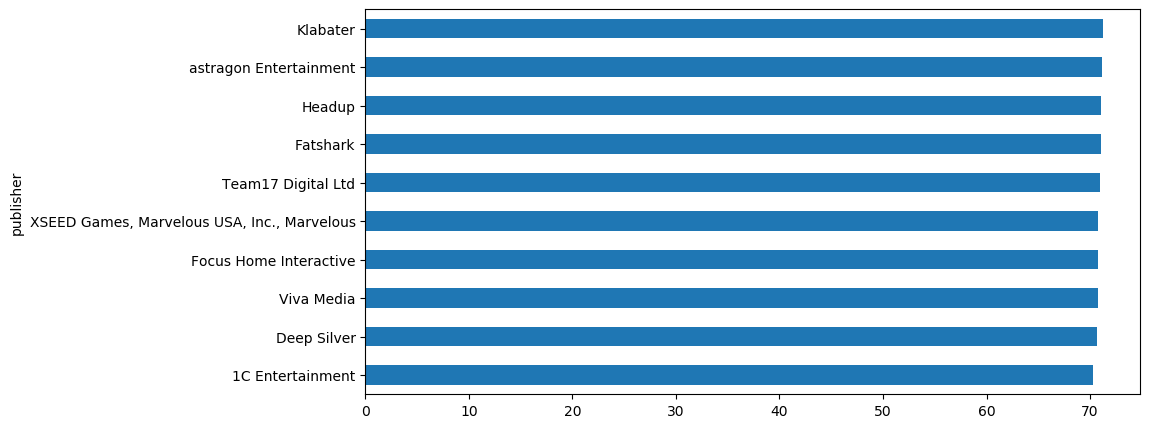

In [472]:
publishers_to_analize = publishers_to_analize.sort_values('avg_publisher_score',ascending=True)
publishers_to_analize.loc[publishers_to_analize.games_released > 20].iloc[:AMT_TO_SEE]['avg_publisher_score'].plot(kind='barh', figsize=(10,5))
publishers_to_analize.loc[publishers_to_analize.games_released > 20].iloc[:AMT_TO_SEE]

1C entretainment seems to be the publisher with the worst mean score but its not that far off the mean so it isn't really that bad.
Let's Check how well were their games over time, going to check the top 5 and some of most known publishers

In [473]:
publishers_to_analize = publishers_to_analize.reset_index()
publishers_to_analize = publishers_to_analize.sort_values('avg_publisher_score',ascending=False) #arrenging them from best to worst

def plot_publisher_over_time(publisher,window=None,ema_value = 1,ylim = None,rule='M'):
    publisher_df = data.loc[data.publisher == publisher][['release_date','metascore']]
    publisher_df = publisher_df.sort_values('release_date',ascending=False)
    publisher_df.set_index('release_date', inplace=True)
    publisher_df[f'EMA_{ema_value}'] = publisher_df['metascore'].ewm(alpha= ema_value, adjust = False).mean()
    publisher_df.resample(rule=rule).mean()[[f'metascore',f'EMA_{ema_value}']].plot(figsize=(12,4),xlim=window, title= f'{publisher} {rule} {window}', ylim= ylim)  
    

In [474]:
publishers_to_analize

,publisher,games_released,avg_publisher_score
16857,ZA/UM,1,97.0
16856,tobyfox,1,92.0
16855,Interplay Corp,1,91.0
16854,Mossmouth,2,90.5
16853,Wube Software LTD.,1,90.0
...,...,...,...
4,PolyPusher Studios,1,39.0
3,Dark Screen Games,1,39.0
2,Vogelsap,1,36.0
1,Epiphany Games,1,32.0


In [475]:
TIMEWINDOW = None
MIN_MAX_SCORE_WINDOW = (60,90)
EMA_VALUE = 0.5
RULE = 'Y'

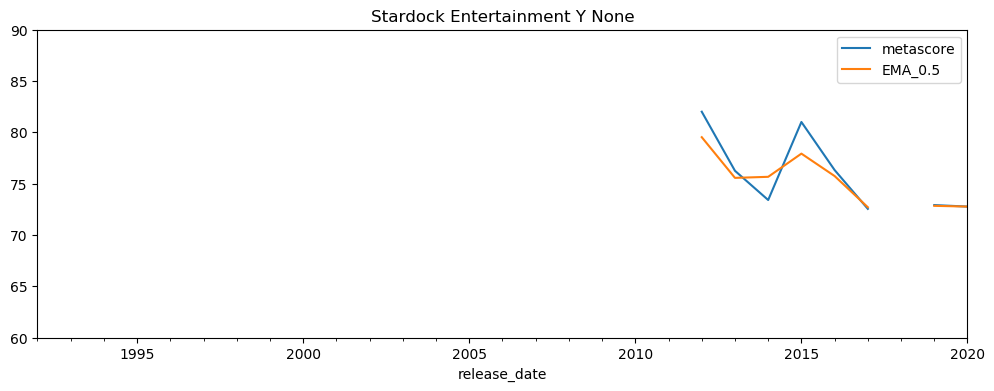

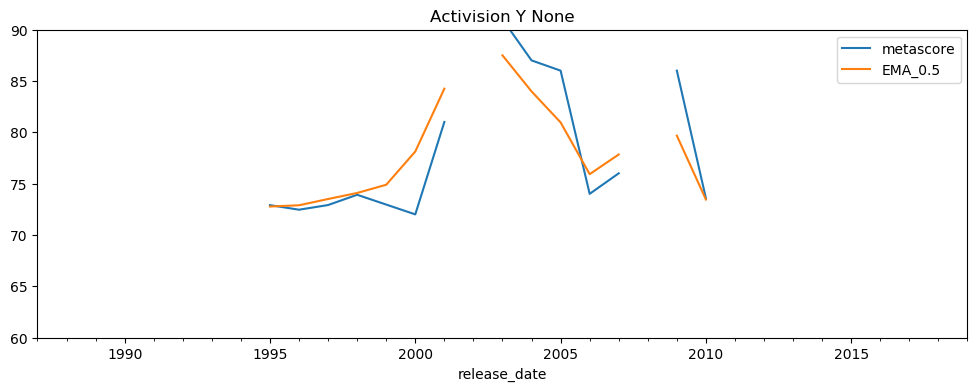

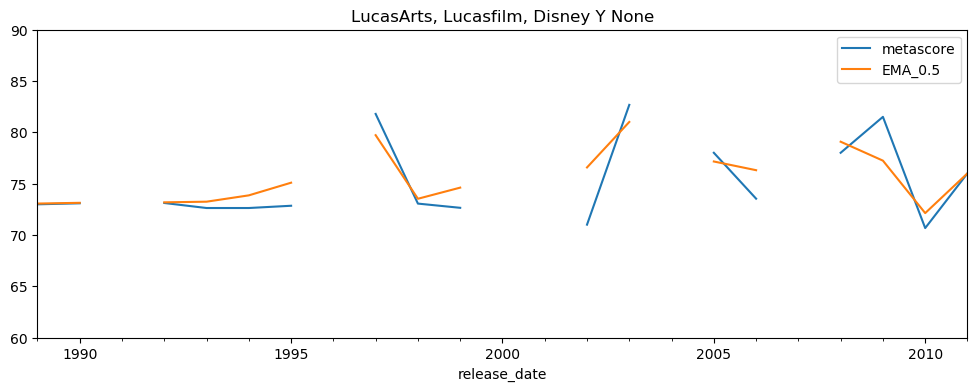

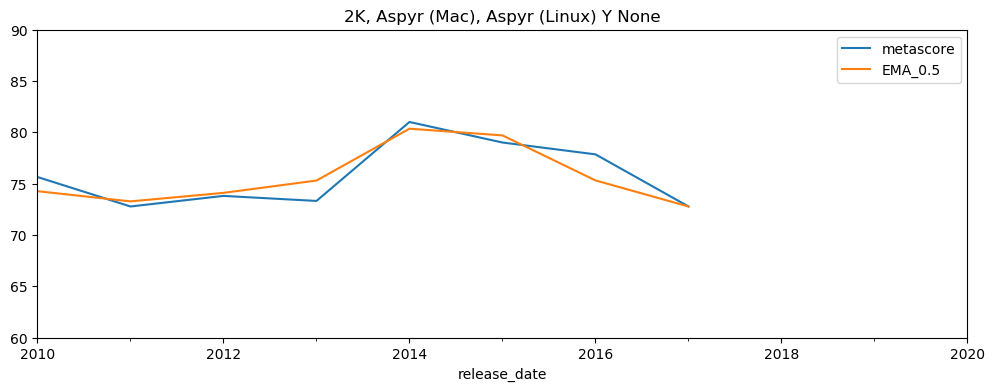

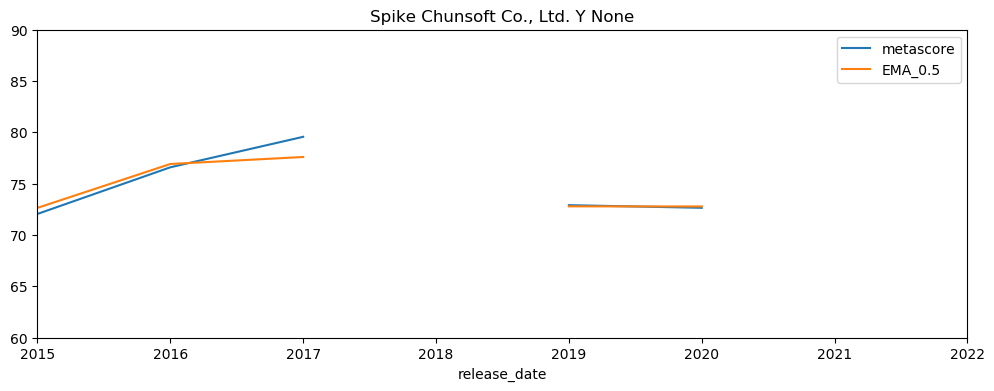

In [476]:
for publisher in publishers_to_analize.loc[publishers_to_analize.games_released > 20].iloc[:5]['publisher']:
    plot_publisher_over_time(publisher,ema_value=EMA_VALUE,ylim=MIN_MAX_SCORE_WINDOW,rule=RULE)

Well there is not much to see, Stardock seems to had it's peak in 2012 and mid 2015 then falling into it's avg after that. Activision shows games upto 2010 which It's mostly beacuse of scrapper error , althoght at some extent activision merged with blizzard-king and started using battlenet launcher/store for some of it's games so that also influenced the lack of samples after 2010, as well as being show as activision-blizzard insted of just Activision.
LucasArt Shows an oscilation between 80+ and ~74.
2k had good period between 2014 and 2015 then it starts falling.
As for Spike Chunsoft, the games that they were releasing from 2015 to 2017 where getting better over time, but on the 2019-2020 period their games weren't recived as well as the ones from the previous period

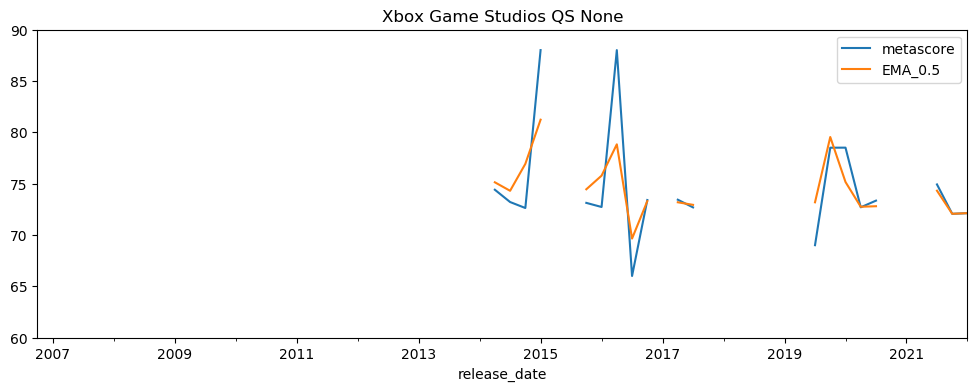

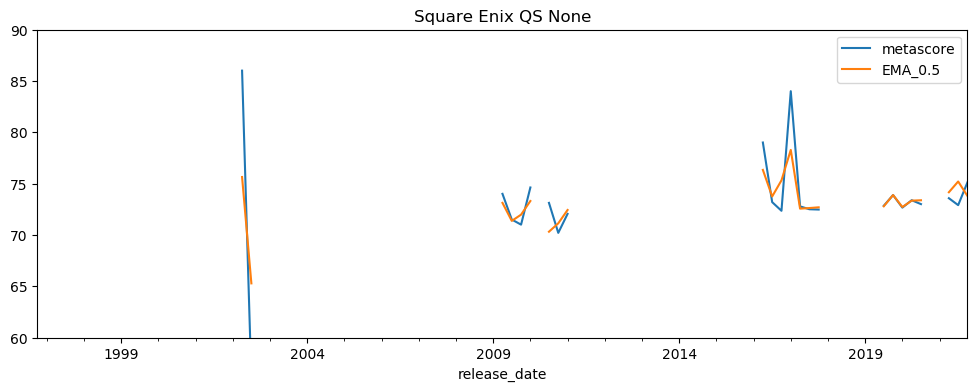

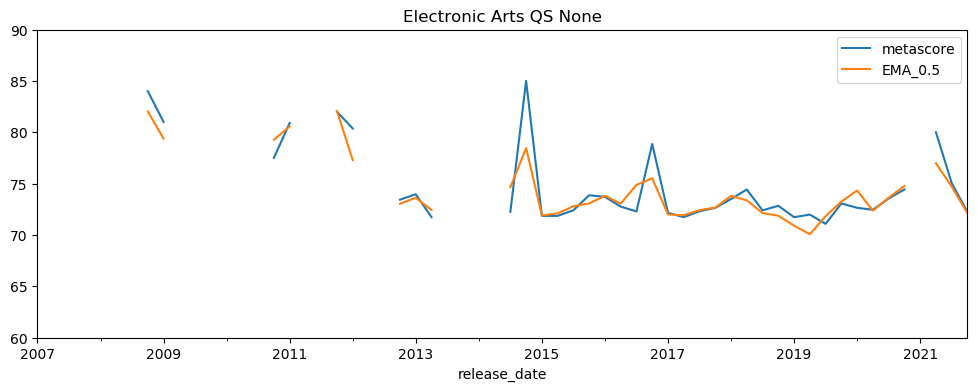

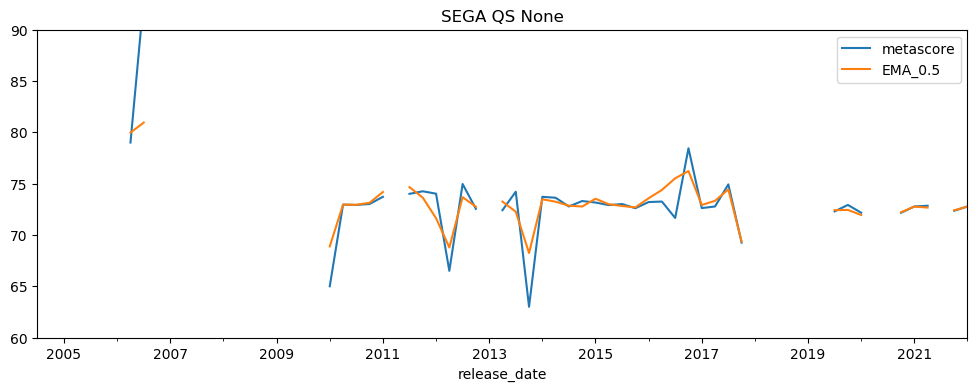

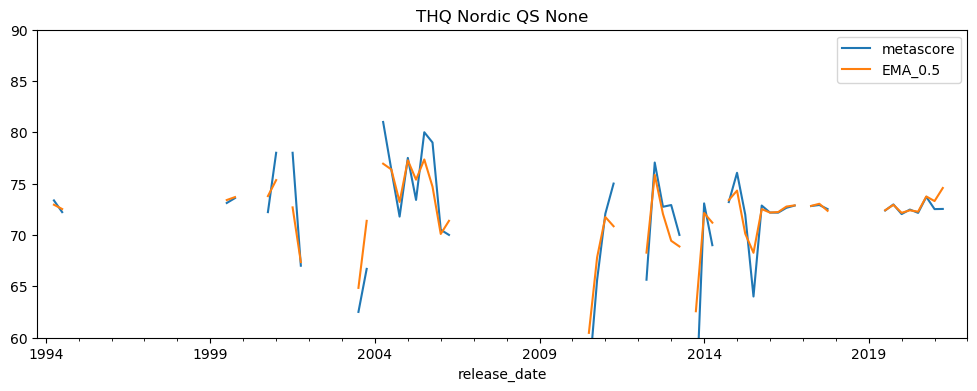

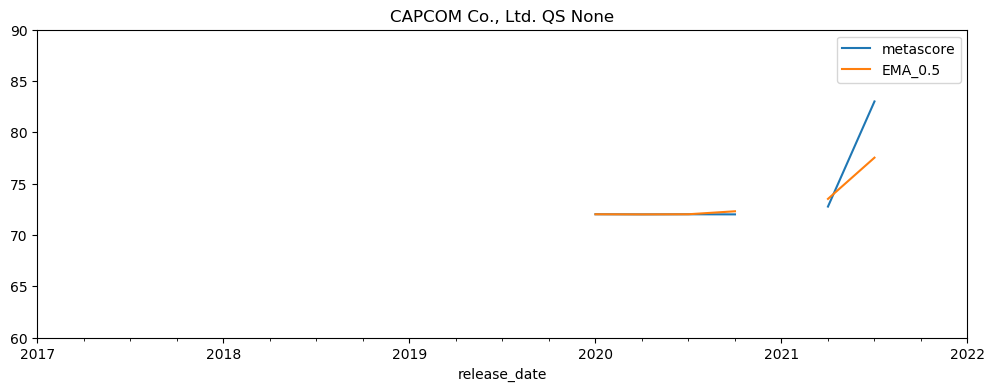

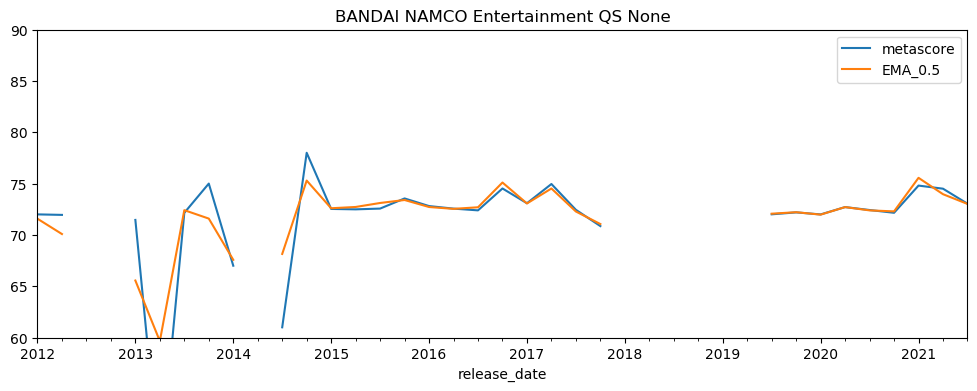

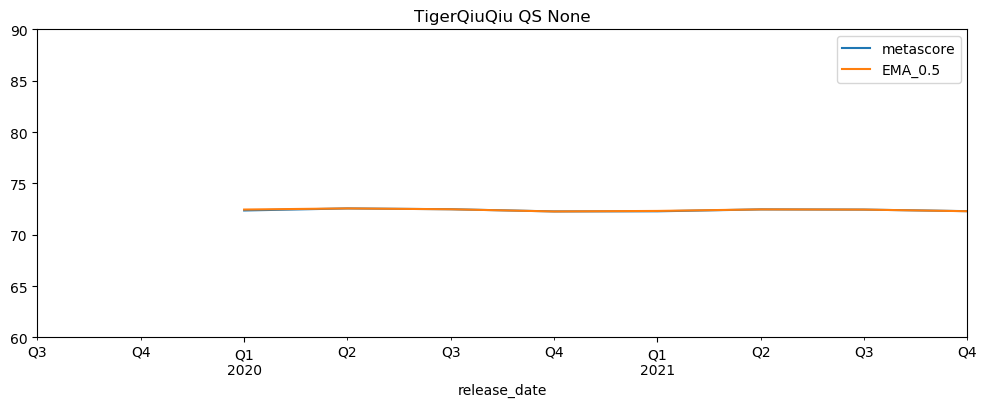

In [477]:
TIMEWINDOW = None
MIN_MAX_SCORE_WINDOW = (60,90)
EMA_VALUE = 0.5
RULE = 'QS'

publishers = ['Xbox Game Studios','Square Enix','Electronic Arts','SEGA','THQ Nordic','CAPCOM Co., Ltd.','BANDAI NAMCO Entertainment','TigerQiuQiu']

for publisher in publishers:
    plot_publisher_over_time(publisher,ema_value=EMA_VALUE,ylim=MIN_MAX_SCORE_WINDOW,rule=RULE)

* Xbox games got good games on 2015 and early 2016, and recently it falls on the avg.
* Square Enix got a good game on 2017 and seems to have released an above avg game recently.
* EA peaked prior to 2015 and on 2017 they got a decent release after that their games are have avg scores (based on the data, it was scrapped just before the bad reception of Batterfield 2042 got mainstream.)
* SEGA 2012 and late 2013 weren't that good, as for more recent releases they seem avg.
* THQ has an oscilateing pattern until 2016 with mid 2011 and late 2013 being its worst, but for more recent games it's been getting improvements
* CAPCOM shows an increase in mid 2021.
* BANDAI NAMCO had a bad 2014 but right now it's avg.
* TigerQiuQiu shows a straight line which is odd, this is due to the company releasing a lot of cheap arcadeish games that after seening some on the store pages, they lacked on score so the line that we see it's mostly due to when I cleaned the metascores.

Let's see the developers now

## 2.5 Developers Analysis

In [478]:
developers_to_analize = pd.DataFrame(data.loc[data.developer != 'Unknown']['developer'])#Ignoring Unkown developers

In [479]:
def count_games_for_developer(value):
    return len(developers_to_analize.loc[data.developer == value])

def get_overall_avg_score_of_developer(value):
    return data.loc[data.developer == value]['metascore'].mean()

In [480]:
developers_to_analize['games_released'] = developers_to_analize['developer'].apply(count_games_for_developer)
developers_to_analize['avg_developer_score'] = developers_to_analize['developer'].apply(get_overall_avg_score_of_developer)

In [481]:
developers_to_analize = developers_to_analize.drop_duplicates(subset=['developer']).reset_index().set_index('developer')
del developers_to_analize['index']
developers_to_analize.describe()

,games_released,avg_developer_score
count,21201.000000,21201.000000
mean,1.761757,72.566712
std,8.015161,2.607955
min,1.000000,27.000000
25%,1.000000,72.290000
50%,1.000000,72.660000
75%,1.000000,72.980000
max,790.000000,97.000000


The mean it's sligthly lower than for publishers(72.61)

,games_released,avg_developer_score
developer,,
TigerQiuQiuTigerQiuQiu,790,72.436595
"KOEI TECMO GAMES CO., LTD.KOEI TECMO GAMES CO., LTD.",651,72.367604
Dovetail GamesDovetail Games - Trains,185,72.117892
"CAPCOM Co., Ltd.CAPCOM Co., Ltd.",184,72.091250
Ubisoft - San FranciscoUbisoft,179,71.987877
Paradox Development StudioParadox Interactive,131,73.250305
The Digital Puzzle CompanyDL Softworks,107,72.363551
Choice of GamesChoice of Games,106,72.867736
Milestone S.r.l.Milestone S.r.l.,90,72.019667


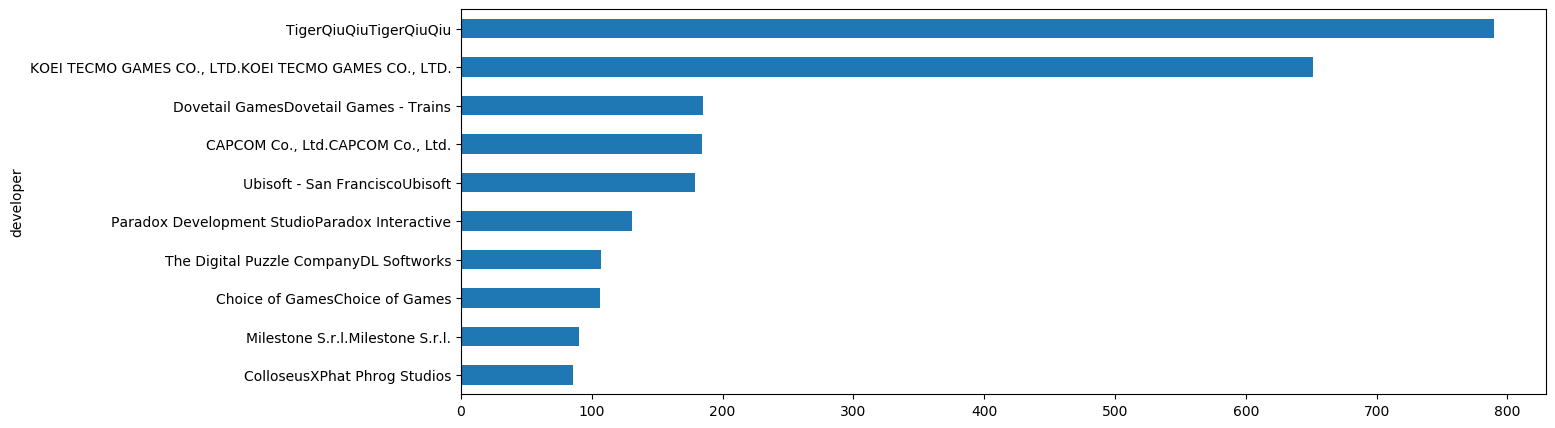

In [482]:
AMT_TO_SEE = 10

developers_to_analize = developers_to_analize.sort_values('games_released',ascending=False)
developers_to_analize.iloc[:AMT_TO_SEE]['games_released'].sort_values(ascending=True).plot(kind='barh', figsize=(14,5))
developers_to_analize[:AMT_TO_SEE]

As we can see TigerQiuQiu and KOEI TECMO are leading in games realeased, seems that some of the dev names are like duplicated in their own row I can still work with it.

,games_released,avg_developer_score
developer,,
"Firaxis Games, Aspyr (Mac), Aspyr (Linux)2K, Aspyr (Mac), Aspyr (Linux)",22,75.023182
HeR InteractiveHeR Interactive,26,74.189231
Daedalic EntertainmentDaedalic Entertainment,27,73.587778
"Murray Atkinson, VGM LibraryDegica",30,73.529667
bitter sweet entertainmentDegica,36,73.518611
Joel SteudlerDegica,47,73.503617
finalbossbluesDegica,22,73.500000
Gee Kun SoftDegica,32,73.500000
"Gotcha Gotcha Games, KADOKAWADegica",35,73.491714


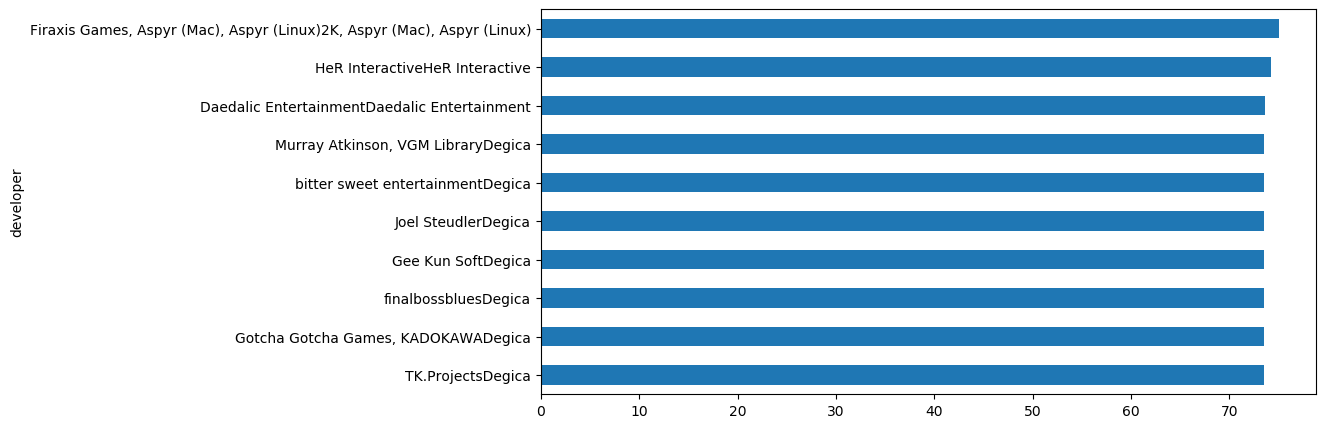

In [483]:
developers_to_analize = developers_to_analize.sort_values('avg_developer_score',ascending=False)
developers_to_analize.loc[developers_to_analize.games_released > 20].iloc[:AMT_TO_SEE]['avg_developer_score'].sort_values(ascending=True).plot(kind='barh', figsize=(10,5))
developers_to_analize.loc[developers_to_analize.games_released > 20].iloc[:AMT_TO_SEE]

2K Aspyr has the best avg score as developer

,games_released,avg_developer_score
developer,,
FatsharkFatshark,23,71.052174
United Independent EntertainmentUnited Independent Entertainment,22,71.512273
Matrix TrainsDovetail Games,35,71.730000
VirtaviaDovetail Games - Flight,29,71.730000
ToposimDovetail Games - Flight,23,71.730000
Dovetail GamesDovetail Games,30,71.753667
Dovetail GamesDovetail Games - TSW,38,71.818421
Just TrainsDovetail Games - Trains,22,71.828182
Racing BrosANPA.US,23,71.925652


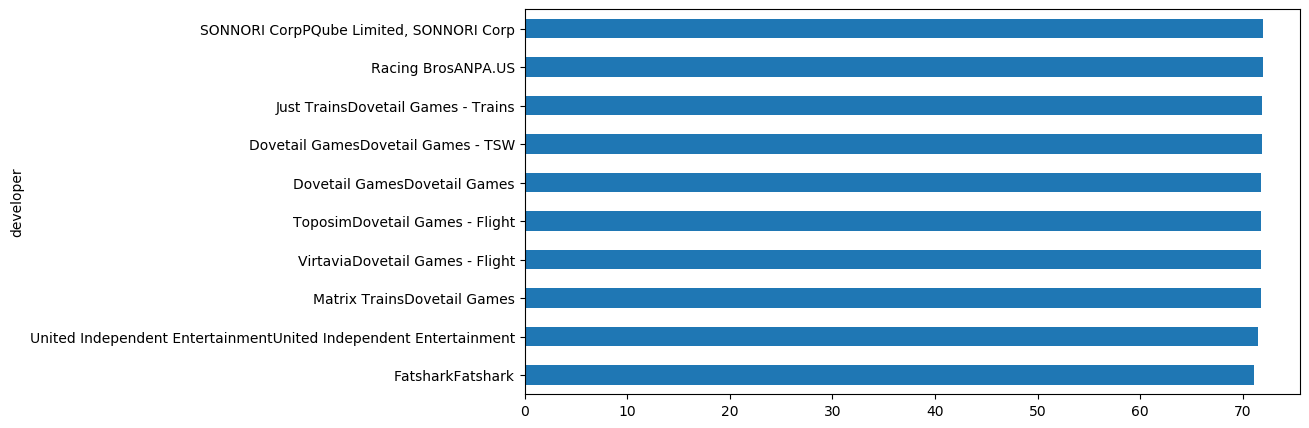

In [484]:
developers_to_analize = developers_to_analize.sort_values('avg_developer_score',ascending=True)
developers_to_analize.loc[developers_to_analize.games_released > 20].iloc[:AMT_TO_SEE]['avg_developer_score'].plot(kind='barh', figsize=(10,5))
developers_to_analize.loc[developers_to_analize.games_released > 20].iloc[:AMT_TO_SEE]

Fatshark has the lowest avg score but its not that far from the avg

In [485]:
developers_to_analize = developers_to_analize.reset_index()
developers_to_analize = developers_to_analize.sort_values('avg_developer_score',ascending=False) #arrenging them from best to worst

def plot_developer_over_time(developer,window=None,ema_value = 1,ylim = None,rule='M'):
    developer_df = data.loc[data.developer == developer][['release_date','metascore']]
    developer_df = developer_df.sort_values('release_date',ascending=False)
    developer_df.set_index('release_date', inplace=True)
    developer_df[f'EMA_{ema_value}'] = developer_df['metascore'].ewm(alpha= ema_value, adjust = False).mean()
    developer_df.resample(rule=rule).mean()[[f'metascore',f'EMA_{ema_value}']].plot(figsize=(12,4),xlim=window, title= f'{developer} {rule} {window}', ylim= ylim)  
    

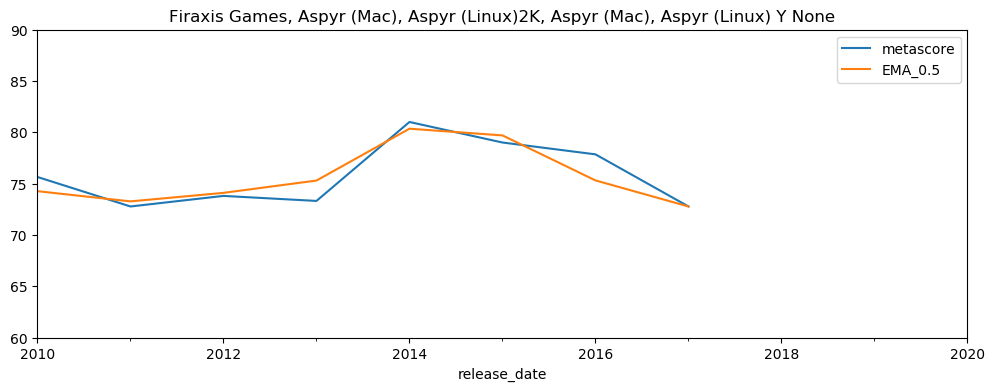

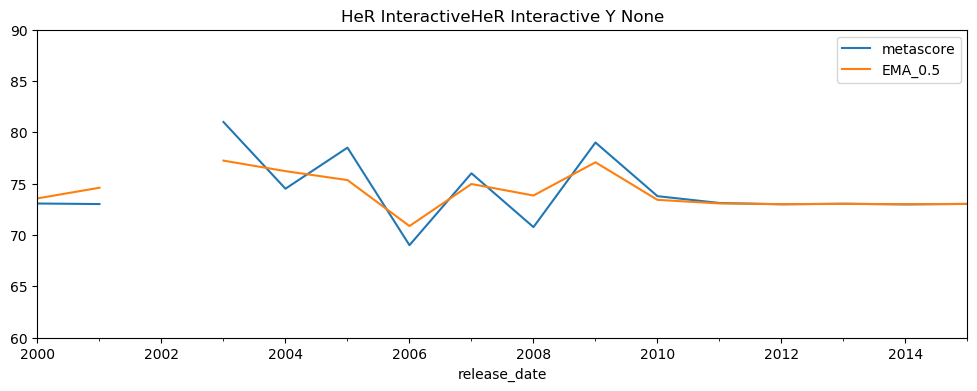

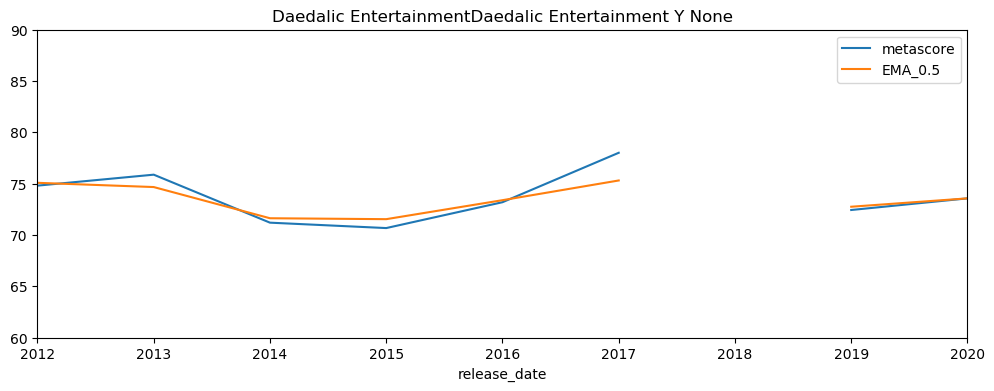

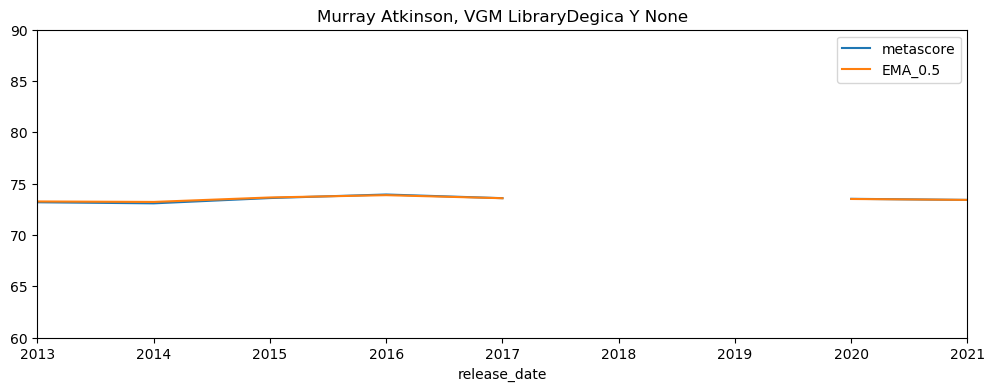

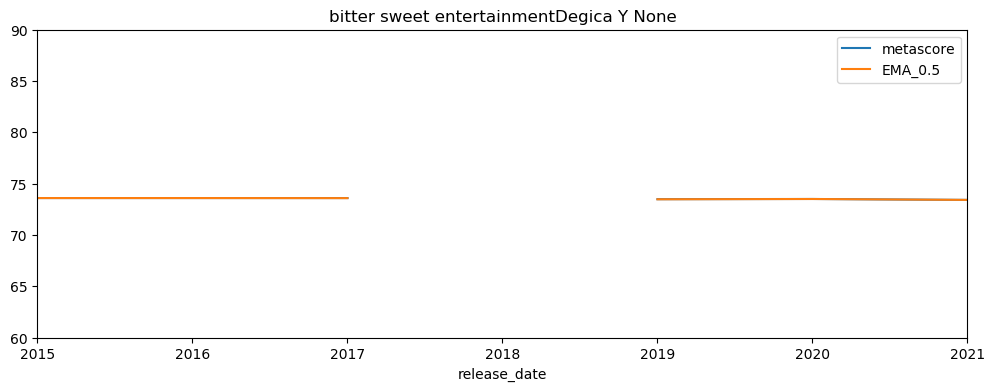

In [486]:
TIMEWINDOW = None
MIN_MAX_SCORE_WINDOW = (60,90)
EMA_VALUE = 0.5
RULE = 'Y'

for developer in developers_to_analize.loc[developers_to_analize.games_released > 20].iloc[:5]['developer']:
    plot_developer_over_time(developer,ema_value=EMA_VALUE,ylim=MIN_MAX_SCORE_WINDOW,rule=RULE)

Murray Atkinson and Degica bitter sweet entretainment show the same pattern that we seen with TigerQiuQiu as publisher, most of the games didn't have a metascore or didn't got the metascore scrapped so we are seeing the cleaned avg.
2K Aspyr shows an up from 2013 to 2014 and slowly starts falling into its avg by 2017
Daelic Entretainment metascores seem to have been improveing over time, there is a gap between 2017 and 2019 thats also shown in other developers, It might has been a scrapper error.

I'll try to find a fix for the developers names, there is sort of a pattern on why they got scrapped bad


## 2.6 final cleaning, fixing developers col and removeing unnecesary cols

In [487]:
test_devs = ['FatsharkFatshark','United Independent EntertainmentUnited Independent Entertainment','VirtaviaDovetail Games - Flight','Dovetail GamesDovetail Games - TSW','SONNORI CorpPQube Limited, SONNORI Corp','Firaxis Games, Aspyr (Mac), Aspyr (Linux)2K, Aspyr (Mac), Aspyr (Linux)','TigerQiuQiu']

In [488]:
dev_clean = []
for dev in test_devs:
    dev_arr = re.findall('[A-Z]+[^A-Z]*', dev)
    words = ""
    previous_word = ""
    for word in dev_arr:
        if word not in words:
            if previous_word.isupper():
                words = words + word
            else:
                words = words + word + " "
            previous_word = word
            
    print(f'{dev}  ===> |{words.replace("  "," ")[:-1]}|')
    
    dev_clean.append(words.replace("  "," ")[:-1])

FatsharkFatshark  ===> |Fatshark|
United Independent EntertainmentUnited Independent Entertainment  ===> |United Independent Entertainment|
VirtaviaDovetail Games - Flight  ===> |Virtavia Dovetail Games - Flight|
Dovetail GamesDovetail Games - TSW  ===> |Dovetail Games Games - TSW|
SONNORI CorpPQube Limited, SONNORI Corp  ===> |SONNORI CorpPQube Limited,|
Firaxis Games, Aspyr (Mac), Aspyr (Linux)2K, Aspyr (Mac), Aspyr (Linux)  ===> |Firaxis Games, Aspyr ( Mac), Linux)2 K,|
TigerQiuQiu  ===> |Tiger Qiu|


In [489]:
#not fully perfect but it works for most of them
def clean_dev(value):
    dev = re.findall('[A-Z]+[^A-Z]*', value)
    words = ""
    previous_word = ""
    for word in dev:
        if word not in words:
            if previous_word.isupper():
                words = words + word
            else:
                words = words + word + " "
            previous_word = word
            
    return words.replace("  "," ")[:-1]

In [490]:
data['developer'] = data['developer'].apply(clean_dev)

In [491]:
data['developer'] = data['developer'].replace('Tiger Qiu','TigerQiuQiu') #Fixing thisone mannually

In [492]:
data['publisher'].value_counts()[:10] #the problem doesn't seem to appear in publishers but im going to apply the function for consistency

Unknown                       7998
TigerQiuQiu                    790
Degica                         761
KOEI TECMO GAMES CO., LTD.     652
Dovetail Games - Trains        374
Paradox Interactive            267
Ubisoft                        253
Big Fish Games                 234
CAPCOM Co., Ltd.               186
Dovetail Games - Flight        179
Name: publisher, dtype: int64

In [493]:
data['publisher'] = data['publisher'].apply(clean_dev)
data['publisher'] = data['publisher'].replace('Tiger Qiu','TigerQiuQiu')

In [494]:
data.columns

Index(['app_name', 'publisher', 'discount_price', 'early_access', 'genres',
       'id', 'metascore', 'price', 'developer', 'release_date', 'reviews_url',
       'sentiment', 'tags', 'title', 'url', 'tag_amnt', 'is_tag_in_tags',
       'gen_amnt', 'is_gen_in_genres', 'tag_avg_metascore',
       'genre_avg_metascore', 'avg_metascore'],
      dtype='object')

In [495]:
# deleting unnesesary cols
del data['reviews_url']
del data['title']
del data['url']
del data['tag_amnt']
del data['is_tag_in_tags']
del data['gen_amnt']
del data['is_gen_in_genres']
del data['price']
del data['discount_price'] 
del data['avg_metascore']

In [496]:
data.to_csv('datasets/dataset_fully_cleaned.csv')

data

,app_name,publisher,early_access,genres,id,metascore,developer,release_date,sentiment,tags,tag_avg_metascore,genre_avg_metascore
0,Gogte,Oso Arcade,1,"[Action, Adventure, Early Access]",1440910.0,73.24,Oso Arcade,2022-01-28,Unknown,"[FPS, Dungeon Crawler, Action, Puzzle, Action-...",72.52,73.97
1,I've Seen Everything - More Fishes,NLB project,0,"[Casual, Indie]",1807515.0,71.94,NLB project,2022-01-28,Unknown,"[Indie, Casual]",72.12,71.77
2,I've Seen Everything - More Dinosaurs,NLB project,0,"[Casual, Indie]",1807514.0,71.94,NLB project,2022-01-28,Unknown,"[Indie, Casual]",72.12,71.77
3,Mini Mini-Golf,Piece Of Voxel,0,"[Casual, Indie, Simulation, Sports, Strategy]",1874400.0,72.66,Piece Of Voxel,2022-01-28,Unknown,"[Casual, Golf, Simulation, Logic, Strategy, Fa...",73.37,71.94
4,Rogue Dungeon,Cerberus Gate Games,1,"[Indie, RPG, Strategy, Early Access]",1822640.0,73.87,Cerberus Gate Games,2022-01-28,Unknown,"[RPG, Adventure, Board Game, Dungeon Crawler, ...",73.83,73.91
...,...,...,...,...,...,...,...,...,...,...,...,...
45345,Frontline: World War II,Frontline: Games Series,0,"[Action, Casual, Indie, Simulation, Strategy]",1394500.0,72.84,Frontline: Games Series,2021-01-01,Positive,"[Turn-Based Tactics, Turn-Based Strategy, Worl...",73.79,71.89
45346,Unification,Unknown,1,[Unknown],1177340.0,73.25,Unknown,2022-01-01,Unknown,"[Early Access, Action Roguelike, Puzzle Platfo...",73.05,73.45
45347,Zoo Strikers,Big Dream,1,"[Action, Casual, Free to Play, Indie, Strategy...",685140.0,72.68,Big Dream,2022-01-01,Unknown,"[Free to Play, Casual, Indie, Action, Strategy...",72.01,73.36
45348,Deadly Maze,Sheer Studios,0,"[Action, Casual, Indie, Massively Multiplayer,...",1319060.0,72.70,Sheer Studios,2021-01-01,Unknown,"[Casual, Strategy, Action, Massively Multiplay...",72.74,72.66


# 3. Prepareing the data and training models

In [542]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('datasets/dataset_fully_cleaned.csv').copy()

y = data.pop('metascore')
X = data

In [543]:
X.columns

Index(['Unnamed: 0', 'app_name', 'publisher', 'early_access', 'genres', 'id',
       'developer', 'release_date', 'sentiment', 'tags', 'tag_avg_metascore',
       'genre_avg_metascore'],
      dtype='object')

In [544]:
X.isna().sum()

Unnamed: 0                0
app_name                  0
publisher              1519
early_access              0
genres                    0
id                        0
developer              1180
release_date              0
sentiment                 0
tags                      0
tag_avg_metascore         0
genre_avg_metascore       0
dtype: int64

In [545]:
del X['Unnamed: 0'] #for some reason this col appears

In [546]:
X['publisher'] = X['publisher'].fillna('unknown')
X['developer'] = X['developer'].fillna('unknown')

In [547]:
num_cols = ['tag_avg_metascore',
       'genre_avg_metascore']

cat_cols = ['publisher', 'early_access', 'developer',
       'release_date', 'sentiment'] #tags and genres cols will be preprocessed separetely

In [548]:
#had problems with sklearn one hot encoder on the 2d cols so I'm encoding them manually
from scipy.sparse import csr_matrix
#assinging an index to each tag/genre, tag and gen lists where created during the EDA they contain each
tag2idx = {u:i for i,u in enumerate(tag_list)}
gen2idx = {u:i for i,u in enumerate(gen_list)}

def one_hot_tags(value):
    if value is str:
        #turning the tag list into a list again
        value = value.replace("'","").replace('"',"").strip('[').strip(']').split(", ") 
    
    vector = np.zeros((len(tag_list)))  #vector filled with 0s with
    #replaceing 0s with 1 on the tag index
    for tag in value:
        if tag == 'Unknown': #replaceing the ph Unknown with None
            tag = None
        if tag in tag2idx:
            vector[tag2idx[tag]] = 1
    return csr_matrix(vector.reshape(-1, 1))

def one_hot_genres(value):
    if value is str:
        #turning the tag list into a list again
        value = value.replace("'","").replace('"',"").strip('[').strip(']').split(", ") 
    
    vector = np.zeros((len(gen2idx)))  #vector filled with 0s
    #replaceing 0s with 1 on the tag index
    for genre in value:
        if genre == 'Unknown':
            tag = None
        if genre in gen2idx:
            vector[gen2idx[genre]] = 1
    return csr_matrix(vector.reshape(-1, 1))

In [549]:
X['tags'] = X['tags'].apply(one_hot_tags)
X['genres'] = X['genres'].apply(one_hot_genres)

In [550]:
#removeing app name and id cols since I'll not use them
del X['app_name']
del X['id']

## 3.1 Train Val Test Spliting, and finishing preparations.

In [551]:
train_amnt = int(len(X) * 0.8)
val_amnt = int(len(X) * 0.1) + train_amnt

X_train, y_train = X[:train_amnt], y[:train_amnt]
X_val, y_val = X[train_amnt:val_amnt], y[train_amnt:val_amnt]
X_test, y_test = X[val_amnt:] , y[val_amnt:]

print(f'Train X: {len(X_train)} Train y: {len(y_train)}\nVal X: {len(X_val)} Val y: {len(y_val)}\nTest X: {len(X_test)} Test y: {len(y_test)}')

Train X: 36280 Train y: 36280
Val X: 4535 Val y: 4535
Test X: 4535 Test y: 4535


In [552]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("imputer",SimpleImputer(strategy="median")),
        ("std_scaler",StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num" , num_pipeline, num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'),cat_cols)
])


X_train = full_pipeline.fit_transform(X_train)
X_val = full_pipeline.transform(X_val)
X_test = full_pipeline.transform(X_test)

## 3.2 Testing base models to see which would be the best performers to adjust later

In [553]:
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

models = []
models.append(['Linear Regression',LinearRegression()])
models.append(['SVR',svm.SVR()])
models.append(['Ridge',Ridge()])
models.append(['Lasso',Lasso()])
models.append(['RandomForest',RandomForestRegressor(random_state=0)])

In [554]:
results = []
for m in models:
    lst_2 = []
    model = m[1]
    model.fit(X_train,y_train)
    mse = mean_squared_error(y_val,model.predict(X_val))
    rmse = np.sqrt(mse)
    results.append([m[0], rmse])
    print(f'finished: {m[0]}')

base_models_results = pd.DataFrame(results,columns=['Model','Val RMSE'])
base_models_results.sort_values('Val RMSE',ascending = True)

finished: Linear Regression
finished: SVR
finished: Ridge
finished: Lasso
finished: RandomForest


,Model,Val RMSE
1,SVR,4.263037
4,RandomForest,4.282999
2,Ridge,4.283606
3,Lasso,4.438608
0,Linear Regression,4.619946


## 3.3 Adjusting top 3 models with GridSearch

In [91]:
from sklearn.model_selection import GridSearchCV

grid_models = [
    (RandomForestRegressor(),[{"n_estimators": [100], "max_features":[2, 4, 8]}]),
    (svm.SVR(),[{'kernel':['poly'],'degree':[1,5],'C':[1,2,0.5]}]),
    (Ridge(),[{'alpha':[0.1,0.25,0.5,1]}])
]

In [92]:
for i,j in grid_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'neg_root_mean_squared_error',cv = 5)
    grid.fit(X_train,y_train)
    best_rmse = grid.best_score_
    best_param = grid.best_params_
    a = '-' * 50
    print(f'\n{a}\n{best_param}\nnegRMSE: {best_rmse}\n')


--------------------------------------------------
{'max_features': 4, 'n_estimators': 100}
negRMSE: -1.8960443831823028


--------------------------------------------------
{'C': 2, 'degree': 1, 'kernel': 'poly'}
negRMSE: -1.8944816966438591


--------------------------------------------------
{'alpha': 1}
negRMSE: -2.0088452753584933



In [555]:
models_grid = []
models_grid.append(['RandomForest grid',RandomForestRegressor(max_features=4, n_estimators=100)])
models_grid.append(['SVR grid',svm.SVR(C= 2, degree= 1, kernel= 'poly')])
models_grid.append(['Ridge grid',Ridge(alpha = 1)])

In [556]:
results = []
for m in models_grid:
    lst_2 = []
    model = m[1]
    model.fit(X_train,y_train)
    mse = mean_squared_error(y_val,model.predict(X_val))
    rmse = np.sqrt(mse)
    results.append([m[0], rmse])
    print(f'finished: {m[0]}')

grid_models_results = pd.DataFrame(results,columns=['Model','Val RMSE'])
grid_models_results.sort_values('Val RMSE',ascending = True)

finished: RandomForest grid
finished: SVR grid
finished: Ridge grid


,Model,Val RMSE
0,RandomForest grid,4.186370
2,Ridge grid,4.283606
1,SVR grid,4.296513


## 3.4 Final Validation results

In [557]:
final_results_table = pd.concat([base_models_results,grid_models_results], ignore_index=True).sort_values('Val RMSE',ascending = True)

In [558]:
final_results_table

,Model,Val RMSE
5,RandomForest grid,4.186370
1,SVR,4.263037
4,RandomForest,4.282999
2,Ridge,4.283606
7,Ridge grid,4.283606
6,SVR grid,4.296513
3,Lasso,4.438608
0,Linear Regression,4.619946


As for the validation RMSE error the best model seems to be the RandomForest grid, going to test the top 3 on the test data to check if it's true

## 3.5 Model results on test data, defining which one its the best model.

In [559]:
models_to_test = []
models_to_test.append(models[1])
models_to_test.append(models[2])
models_to_test.append(models_grid[0])

results = []
for m in models_to_test:
    lst_2 = []
    model = m[1]
    mse = mean_squared_error(y_test,model.predict(X_test))
    rmse = np.sqrt(mse)
    results.append([m[0], rmse])
    print(f'finished: {m[0]}')

test_results_table = pd.DataFrame(results,columns=['Model','Test RMSE'])
test_results_table.sort_values('Test RMSE',ascending = True)

finished: SVR
finished: Ridge
finished: RandomForest grid


,Model,Test RMSE
0,SVR,1.269942
2,RandomForest grid,1.282277
1,Ridge,1.329456


### The best Model is the default SVR with a test RMSE 1.269942

In [560]:
#The cells bellow are for makeing the presentation and utils for the predict function sice it will be needing the avg scores for tag and genres.

# Getting images of test and val results
import dataframe_image as dfi

dfi.export(test_results_table, 'imgs/test_results_table.png')
dfi.export(final_results_table, 'imgs/val_results_table.png')

#exporting tags and genres avg scores since they are needed to do the predictions outside this notebook 

tag_scores_df = pd.DataFrame()
tag_scores_df['tag'] = tag_scores.keys()
tag_scores_df['avg_score'] = tag_scores.values()
tag_scores_df['avg_score'] = tag_scores_df['avg_score'].fillna(tag_scores_df['avg_score'].mean())

gen_scores_df = pd.DataFrame()
gen_scores_df['genre'] = gen_scores.keys()
gen_scores_df['avg_score'] = gen_scores.values()
gen_scores_df['avg_score'] = gen_scores_df['avg_score'].fillna(gen_scores_df['avg_score'].mean())

tag_scores_df.to_csv('datasets/tags_avg_scores.csv')
gen_scores_df.to_csv('datasets/genres_avg_scores.csv')



In [734]:
#load model
model = models[1][1]

#Utils

def one_hot_tags(value):
    
    if value is str:
        #turning the tag list into a list again
        value = value.replace("'","").replace('"',"").strip('[').strip(']').split(", ") 
    
    vector = np.zeros((len(tag_list)))  #vector filled with 0s with
    #replaceing 0s with 1 on the tag index
    if value:
        for tag in value:
            if tag == 'Unknown': #replaceing the ph Unknown with None
                tag = None
            if tag in tag2idx and tag:
                vector[tag2idx[tag]] = 1
    return csr_matrix(vector.reshape(-1, 1))

def one_hot_genres(value):

    if value is str:
        #turning the tag list into a list again
        value = value.replace("'","").replace('"',"").strip('[').strip(']').split(", ") 
    
    vector = np.zeros((len(gen2idx)))  #vector filled with 0s
    #replaceing 0s with 1 on the tag index
    if value:
        for genre in value:
            if genre == 'Unknown':
                tag = None
            if genre in gen2idx and genre:
                vector[gen2idx[genre]] = 1
    return csr_matrix(vector.reshape(-1, 1))

def calculate_avg_tags_scores(tags:list):
    tag_scores = pd.read_csv('datasets/tags_avg_scores.csv')
    avg = 0
    if tags:
        for tag in tags:
            if tag and len(tag_scores.loc[tag_scores.tag==tag]['avg_score']) > 0:
                avg_tag = tag_scores.loc[tag_scores.tag==tag]['avg_score'].values[0]
                avg = avg + avg_tag
            else:
                avg = avg + tag_scores['avg_score'].mean()
        return avg / len(tags)
    else:
        return tag_scores['avg_score'].mean()

def calculate_avg_genres_scores(genres:list):
    genres_scores = pd.read_csv('datasets/genres_avg_scores.csv')
    avg = 0
    if genres:
        for genre in genres:
            if genre and len(genres_scores.loc[genres_scores.genre==genre]['avg_score']) > 0:
                avg_genre = genres_scores.loc[genres_scores.genre==genre]['avg_score'].values[0]
                avg = avg + avg_genre
            else:
                avg = avg + genres_scores['avg_score'].mean()
        return avg / len(genres)
    else:
        return genres_scores['avg_score'].mean()

def clear_realease_date(value):
    try:
        if isinstance(value, datetime):
            return value
        elif 12 > len(value) > 8:
            return datetime.strptime(value, '%d %b %Y')
        else:
            return datetime.strptime(value[-11:], '%d %b %Y')
    except:
        return datetime.strptime('1 Jan 2022' , '%d %b %Y') 
    
def predict(tags = [None], genres = [None], early_access = False, publisher = 'Unknown', developer = 'Unknown', release_date = '1 Jan 2022', sentiment= 'Unknown'):
    
    #preproccesing Inputs
    early_access = int(early_access == True)
    tag_avg = calculate_avg_tags_scores(tags)
    genres_avg = calculate_avg_genres_scores(genres)
    release_date = clear_realease_date(release_date)
    
    values =[[publisher,int(early_access),genres,developer,release_date,sentiment,tags,tag_avg,genres_avg]]
    df = pd.DataFrame(values,columns=['publisher','early_access','genres','developer','release_date','sentiment','tags','tag_avg_metascore','genre_avg_metascore'])
    df['release_date'] = df['release_date'].astype(object)
    df['tags'] = df['tags'].apply(one_hot_tags)
    df['genres'] = df['genres'].apply(one_hot_genres)

    full_pipeline.transform(df)
    return model.predict(df)

1